<a href="https://colab.research.google.com/github/miamvmian/SciML/blob/main/Seminar%204_student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From fully connected layers to convolutions

The seminar is based on the interactive books "Dive into Deep Learning" and "Physics-based deep learning" and materials from Rick Wierenga and towarddatascience blog. Additional information is taken from paper "An Introduction to Variational Autoencoders".


## Invariance

Suppose we want to identify an object within an image. It makes sense that our recognition method shouldn't depend too much on the object's exact position. Ideally, our approach should take advantage of this fact. For example, pigs are rarely found flying and airplanes don't usually swim, but even so, our system should still be able to recognize a pig if it appears at the top of the image.

In other words, a robust object detection system should be able to identify objects regardless of where they appear in the image, making use of prior knowledge about typical object locations, but not being limited by it.

We can clarify these intuitive ideas by listing several criteria that help us design neural network architectures ideal for computer vision tasks:

1. The initial layers of our network should react in the same way to an identical image patch, no matter its position. This property is called *translation invariance* (sometimes also called *translation equivariance*).
2. The earliest layers ought to concentrate on small, local regions and ignore distant parts of the image. This is known as the *locality* principle. Over time, these local features can be combined to produce predictions for the entire image.
3. As we move deeper, the network’s layers should be able to capture features spanning broader and more complex regions, resembling higher-level visual perception found in nature.

Let’s explore how these concepts can be expressed mathematically.


## Constraining the MLP

To start off, we can consider an MLP
with two-dimensional images $\mathbf{X}$ as inputs
and their immediate hidden representations
$\mathbf{H}$ similarly represented as matrices (they are two-dimensional tensors in code), where both $\mathbf{X}$ and $\mathbf{H}$ have the same shape.
Let that sink in.
We now imagine that not only the inputs but
also the hidden representations possess spatial structure.

Let $[\mathbf{X}]_{i, j}$ and $[\mathbf{H}]_{i, j}$ denote the pixel
at location $(i,j)$
in the input image and hidden representation, respectively.
Consequently, to have each of the hidden units
receive input from each of the input pixels,
we would switch from using weight matrices
(as we did previously in MLPs)
to representing our parameters
as fourth-order weight tensors $\mathsf{W}$.
Suppose that $\mathbf{U}$ contains biases,
we could formally express the fully connected layer as

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

The switch from $\mathsf{W}$ to $\mathsf{V}$ is entirely cosmetic for now
since there is a one-to-one correspondence
between coefficients in both fourth-order tensors.
We simply re-index the subscripts $(k, l)$
such that $k = i+a$ and $l = j+b$.
In other words, we set $[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$.
The indices $a$ and $b$ run over both positive and negative offsets,
covering the entire image.
For any given location ($i$, $j$) in the hidden representation $[\mathbf{H}]_{i, j}$,
we compute its value by summing over pixels in $x$,
centered around $(i, j)$ and weighted by $[\mathsf{V}]_{i, j, a, b}$. Before we carry on, let's consider the total number of parameters required for a *single* layer in this parametrization: a $1000 \times 1000$ image (1 megapixel) is mapped to a $1000 \times 1000$ hidden representation. This requires $10^{12}$ parameters, far beyond what computers currently can handle.  

### Translation Invariance

Now let's invoke the first principle
established above: translation invariance.
This implies that a shift in the input $\mathbf{X}$
should simply lead to a shift in the hidden representation $\mathbf{H}$.
This is only possible if $\mathsf{V}$ and $\mathbf{U}$ do not actually depend on $(i, j)$. As such,
we have $[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$ and $\mathbf{U}$ is a constant, say $u$.
As a result, we can simplify the definition for $\mathbf{H}$:

$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$


This is a *convolution*!

###  Locality

Now let's invoke the second principle: locality.
As motivated above, we believe that we should not have
to look very far away from location $(i, j)$
in order to glean relevant information
to assess what is going on at $[\mathbf{H}]_{i, j}$.
This means that outside some range $|a|> \Delta$ or $|b| > \Delta$,
we should set $[\mathbf{V}]_{a, b} = 0$.
Equivalently, we can rewrite $[\mathbf{H}]_{i, j}$ as

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$

*Convolutional neural networks* (CNNs)
are a special family of neural networks that contain convolutional layers.
In the deep learning research community,
$\mathbf{V}$ is referred to as a *convolution kernel*,
a *filter*, or simply the layer's *weights* that are learnable parameters.

## Convolutions

Let's briefly review why it is called a convolution.
In mathematics, the *convolution* between two functions is defined as

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

That is, we measure the overlap between $f$ and $g$
when one function is "flipped" and shifted by $\mathbf{x}$.
Whenever we have discrete objects, the integral turns into a sum.
For instance, for vectors from
the set of square-summable infinite-dimensional vectors
with index running over $\mathbb{Z}$ we obtain the following definition:

$$(f * g)(i) = \sum_a f(a) g(i-a).$$

For two-dimensional tensors, we have a corresponding sum
with indices $(a, b)$ for $f$ and $(i-a, j-b)$ for $g$, respectively:

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).$$

This looks similar, with one major difference.
Rather than using $(i+a, j+b)$, we are using the difference instead.
Note, though, that this distinction is mostly cosmetic.
Our original definition more properly
describes a *cross-correlation*.
We will come back to this in the following section.


## Channels

To support multiple channels in both inputs ($\mathsf{X}$) and hidden representations ($\mathsf{H}$),
we can add a fourth coordinate to $\mathsf{V}$: $[\mathsf{V}]_{a, b, c, d}$.
Putting everything together we have:

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$$

where $d$ indexes the output channels in the hidden representations $\mathsf{H}$. The subsequent convolutional layer will go on to take a third-order tensor, $\mathsf{H}$, as input.

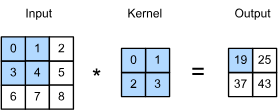


In the two-dimensional cross-correlation operation,
we begin with the convolution window positioned
at the upper-left corner of the input tensor
and slide it across the input tensor,
both from left to right and top to bottom.
When the convolution window slides to a certain position,
the input subtensor contained in that window
and the kernel tensor are multiplied elementwise
and the resulting tensor is summed up
yielding a single scalar value.
This result gives the value of the output tensor
at the corresponding location.
Here, the output tensor has a height of 2 and width of 2
and the four elements are derived from
the two-dimensional cross-correlation operation:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than $1$,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_\textrm{h} \times n_\textrm{w}$
minus the size of the convolution kernel $k_\textrm{h} \times k_\textrm{w}$
via

$$(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.
Later we will see how to keep the size unchanged
by padding the image with zeros around its boundary
so that there is enough space to shift the kernel.
Let's implement this process in the `corr2d` function,
which accepts an input tensor `X` and a kernel tensor `K`
and returns an output tensor `Y`.

In [ ]:
import torch

def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            # WRITE YOUR CODE HERE
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)


We are now ready to **implement a two-dimensional convolutional layer**
based on the `corr2d` function defined above.
In the `__init__` constructor method,
we declare `weight` and `bias` as the two model parameters.
The forward propagation method
calls the `corr2d` function and adds the bias.

In [ ]:
from torch import nn
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return # WRITE YOUR CODE HERE

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

In [ ]:
corr2d(X.t(), K)

In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

## Cross-Correlation and Convolution

Here let's continue to consider two-dimensional convolutional layers.
What if such layers
perform strict convolution operations instead of cross-correlations?
In order to obtain the output of the strict *convolution* operation, we only need to flip the two-dimensional kernel tensor both horizontally and vertically, and then perform the *cross-correlation* operation with the input tensor.

It is noteworthy that since kernels are learned from data in deep learning,
the outputs of convolutional layers remain unaffected
no matter such layers
perform
either the strict convolution operations
or the cross-correlation operations.

To illustrate this, suppose that a convolutional layer performs *cross-correlation* and learns the kernel, which is here denoted as the matrix $\mathbf{K}$.
Assuming that other conditions remain unchanged,
when this layer instead performs strict *convolution*,
the learned kernel $\mathbf{K}'$ will be the same as $\mathbf{K}$
after $\mathbf{K}'$ is
flipped both horizontally and vertically.
That is to say,
when the convolutional layer
performs strict *convolution*,
the same output (cross-correlation of the input and $\mathbf{K}$)
will be obtained.

In keeping with standard terminology in deep learning literature,
we will continue to refer to the cross-correlation operation
as a convolution even though, strictly-speaking, it is slightly different.
Furthermore,
we use the term *element* to refer to
an entry (or component) of any tensor representing a layer representation or a convolution kernel.

## Padding

One tricky issue when applying convolutional layers
is that we tend to lose pixels on the perimeter of our image. Consider that depicts the pixel utilization as a function of the convolution kernel size and the position within the image. The pixels in the corners are hardly used at all.

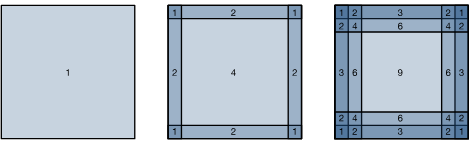

Since we typically use small kernels,
for any given convolution
we might only lose a few pixels
but this can add up as we apply
many successive convolutional layers.
One straightforward solution to this problem
is to add extra pixels of filler around the boundary of our input image,
thus increasing the effective size of the image.
The corresponding output then increases to a $4 \times 4$ matrix.
The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+0\times2+0\times3=0$.

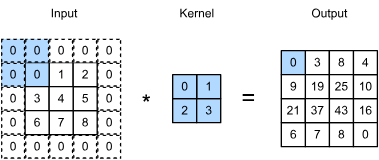

In general, if we add a total of $p_\textrm{h}$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_\textrm{w}$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+1)\times(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+1).$$

This means that the height and width of the output
will increase by $p_\textrm{h}$ and $p_\textrm{w}$, respectively.

In many cases, we will want to set $p_\textrm{h}=k_\textrm{h}-1$ and $p_\textrm{w}=k_\textrm{w}-1$
to give the input and output the same height and width.
This will make it easier to predict the output shape of each layer
when constructing the network.
Assuming that $k_\textrm{h}$ is odd here,
we will pad $p_\textrm{h}/2$ rows on both sides of the height.
If $k_\textrm{h}$ is even, one possibility is to
pad $\lceil p_\textrm{h}/2\rceil$ rows on the top of the input
and $\lfloor p_\textrm{h}/2\rfloor$ rows on the bottom.
We will pad both sides of the width in the same way.

CNNs commonly use convolution kernels
with odd height and width values, such as 1, 3, 5, or 7.
Choosing odd kernel sizes has the benefit
that we can preserve the dimensionality
while padding with the same number of rows on top and bottom,
and the same number of columns on left and right.

Moreover, this practice of using odd kernels
and padding to precisely preserve dimensionality
offers a clerical benefit.
For any two-dimensional tensor `X`,
when the kernel's size is odd
and the number of padding rows and columns
on all sides are the same,
thereby producing an output with the same height and width as the input,
we know that the output `Y[i, j]` is calculated
by cross-correlation of the input and convolution kernel
with the window centered on `X[i, j]`.

In the following example, we create a two-dimensional convolutional layer
with a height and width of 3
and (**apply 1 pixel of padding on all sides.**)
Given an input with a height and width of 8,
we find that the height and width of the output is also 8.


In [ ]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

In [ ]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

## Stride

When computing the cross-correlation,
we start with the convolution window
at the upper-left corner of the input tensor,
and then slide it over all locations both down and to the right.
In the previous examples, we defaulted to sliding one element at a time.
However, sometimes, either for computational efficiency
or because we wish to downsample,
we move our window more than one element at a time,
skipping the intermediate locations. This is particularly useful if the convolution
kernel is large since it captures a large area of the underlying image.

We refer to the number of rows and columns traversed per slide as *stride*.
So far, we have used strides of 1, both for height and width.
Sometimes, we may want to use a larger stride.

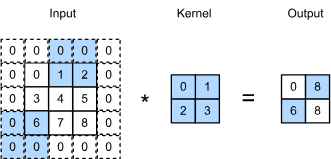

![Cross-correlation with strides of 3 and 2 for height and width, respectively.]

In general, when the stride for the height is $s_\textrm{h}$
and the stride for the width is $s_\textrm{w}$, the output shape is

$$\lfloor(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+s_\textrm{h})/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+s_\textrm{w})/s_\textrm{w}\rfloor.$$

If we set $p_\textrm{h}=k_\textrm{h}-1$ and $p_\textrm{w}=k_\textrm{w}-1$,
then the output shape can be simplified to
$\lfloor(n_\textrm{h}+s_\textrm{h}-1)/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}+s_\textrm{w}-1)/s_\textrm{w}\rfloor$.
Going a step further, if the input height and width
are divisible by the strides on the height and width,
then the output shape will be $(n_\textrm{h}/s_\textrm{h}) \times (n_\textrm{w}/s_\textrm{w})$.

Below, we **set the strides on both the height and width to 2**,
thus halving the input height and width.


In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

## Multiple Input Channels

When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_\textrm{i}$,
the number of input channels of the convolution kernel also needs to be $c_\textrm{i}$. If our convolution kernel's window shape is $k_\textrm{h}\times k_\textrm{w}$,
then, when $c_\textrm{i}=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_\textrm{h}\times k_\textrm{w}$.

However, when $c_\textrm{i}>1$, we need a kernel
that contains a tensor of shape $k_\textrm{h}\times k_\textrm{w}$ for *every* input channel. Concatenating these $c_\textrm{i}$ tensors together
yields a convolution kernel of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
Since the input and convolution kernel each have $c_\textrm{i}$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_\textrm{i}$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

Let's provide an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

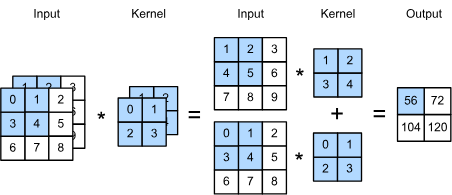




To make sure we really understand what is going on here,
we can **implement cross-correlation operations with multiple input channels** ourselves.
Notice that all we are doing is performing a cross-correlation operation
per channel and then adding up the results.

In [ ]:
import torch.nn.functional as F
from torch import nn # Import nn

def corr2d_multi_in(X, K):
    # X shape: (c_i, h, w)
    # K shape: (c_i, k_h, k_w)
    # Summing over the 0th dimension (input channels)
    # of the results of the cross-correlation operation
    # for each input channel.

    # WRITE YOUR CODE HERE

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

In [ ]:
K.shape

## Multiple Output Channels

Regardless of the number of input channels,
so far we always ended up with one output channel.
However, as we discussed previously,
it turns out to be essential to have multiple channels at each layer.
In the most popular neural network architectures,
we actually increase the channel dimension
as we go deeper in the neural network,
typically downsampling to trade off spatial resolution
for greater *channel depth*.
Intuitively, you could think of each channel
as responding to a different set of features.
The reality is a bit more complicated than this. A naive interpretation would suggest
that representations are learned independently per pixel or per channel.
Instead, channels are optimized to be jointly useful.
This means that rather than mapping a single channel to an edge detector, it may simply mean
that some direction in channel space corresponds to detecting edges.

Denote by $c_\textrm{i}$ and $c_\textrm{o}$ the number
of input and output channels, respectively,
and by $k_\textrm{h}$ and $k_\textrm{w}$ the height and width of the kernel.
To get an output with multiple channels,
we can create a kernel tensor
of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$
for *every* output channel.
We concatenate them on the output channel dimension,
so that the shape of the convolution kernel
is $c_\textrm{o}\times c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
In cross-correlation operations,
the result on each output channel is calculated
from the convolution kernel corresponding to that output channel
and takes input from all channels in the input tensor.

We implement a cross-correlation function
to **calculate the output of multiple channels** as shown below.


In [ ]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together

    #  WRITE YOUR CODE HERE

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

In [ ]:
corr2d_multi_in_out(X, K)

## $1\times 1$ Convolutional Layer

At first, a [**$1 \times 1$ convolution**], i.e., $k_\textrm{h} = k_\textrm{w} = 1$,
does not seem to make much sense.
After all, a convolution correlates adjacent pixels.
A $1 \times 1$ convolution obviously does not.
Nonetheless, they are popular operations that are sometimes included
in the designs of complex deep networks.
Let's see in some detail what it actually does.

Because the minimum window is used,
the $1\times 1$ convolution loses the ability
of larger convolutional layers
to recognize patterns consisting of interactions
among adjacent elements in the height and width dimensions.
The only computation of the $1\times 1$ convolution occurs
on the channel dimension.

Figure shows the cross-correlation computation
using the $1\times 1$ convolution kernel
with 3 input channels and 2 output channels.
Note that the inputs and outputs have the same height and width.
Each element in the output is derived
from a linear combination of elements *at the same position*
in the input image.
You could think of the $1\times 1$ convolutional layer
as constituting a fully connected layer applied at every single pixel location
to transform the $c_\textrm{i}$ corresponding input values into $c_\textrm{o}$ output values.
Because this is still a convolutional layer,
the weights are tied across pixel location.
Thus the $1\times 1$ convolutional layer requires $c_\textrm{o}\times c_\textrm{i}$ weights
(plus the bias). Also note that convolutional layers are typically followed
by nonlinearities. This ensures that $1 \times 1$ convolutions cannot simply be
folded into other convolutions.

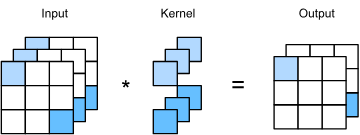

Let's check whether this works in practice:
we implement a $1 \times 1$ convolution
using a fully connected layer.
The only thing is that we need to make some adjustments
to the data shape before and after the matrix multiplication.


In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    # WRITE YOUR CODE HERE
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-5

## Maximum Pooling and Average Pooling

Like convolutional layers, *pooling* operators
consist of a fixed-shape window that is slid over
all regions in the input according to its stride,
computing a single output for each location traversed
by the fixed-shape window (sometimes known as the *pooling window*).
However, unlike the cross-correlation computation
of the inputs and kernels in the convolutional layer,
the pooling layer contains no parameters (there is no *kernel*).
Instead, pooling operators are deterministic,
typically calculating either the maximum or the average value
of the elements in the pooling window.
These operations are called *maximum pooling* (*max-pooling* for short)
and *average pooling*, respectively.

*Average pooling* is essentially as old as CNNs. The idea is akin to
downsampling an image. Rather than just taking the value of every second (or third)
pixel for the lower resolution image, we can average over adjacent pixels to obtain
an image with better signal-to-noise ratio since we are combining the information
from multiple adjacent pixels. *Max-pooling* was introduced in
:citet:`Riesenhuber.Poggio.1999` in the context of cognitive neuroscience to describe
how information aggregation might be aggregated hierarchically for the purpose
of object recognition; there already was an earlier version in speech recognition :cite:`Yamaguchi.Sakamoto.Akabane.ea.1990`. In almost all cases, max-pooling, as it is also referred to,
is preferable to average pooling.

In both cases, as with the cross-correlation operator,
we can think of the pooling window
as starting from the upper-left of the input tensor
and sliding across it from left to right and top to bottom.
At each location that the pooling window hits,
it computes the maximum or average
value of the input subtensor in the window,
depending on whether max or average pooling is employed.


![Max-pooling with a pooling window shape of $2\times 2$. The shaded portions are the first output element as well as the input tensor elements used for the output computation: $\max(0, 1, 3, 4)=4$.](http://d2l.ai/_images/pooling.svg)

The output tensor  has a height of 2 and a width of 2.
The four elements are derived from the maximum value in each pooling window:

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

More generally, we can define a $p \times q$ pooling layer by aggregating over
a region of said size. Returning to the problem of edge detection,
we use the output of the convolutional layer
as input for $2\times 2$ max-pooling.
Denote by `X` the input of the convolutional layer input and `Y` the pooling layer output.
Regardless of whether or not the values of `X[i, j]`, `X[i, j + 1]`,
`X[i+1, j]` and `X[i+1, j + 1]` are different,
the pooling layer always outputs `Y[i, j] = 1`.
That is to say, using the $2\times 2$ max-pooling layer,
we can still detect if the pattern recognized by the convolutional layer
moves no more than one element in height or width.

In the code below, we **implement the forward propagation
of the pooling layer** in the `pool2d` function.
This function is similar to the `corr2d` function
in :numref:`sec_conv_layer`.
However, no kernel is needed, computing the output
as either the maximum or the average of each region in the input.


In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                # WRITE YOUR CODE HERE
            elif mode == 'avg':
                # WRITE YOUR CODE HERE
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

In [ ]:
pool2d(X, (2, 2), 'avg')

## Padding and Stride

As with convolutional layers, pooling layers
change the output shape.
And as before, we can adjust the operation to achieve a desired output shape
by padding the input and adjusting the stride.
We can demonstrate the use of padding and strides
in pooling layers via the built-in two-dimensional max-pooling layer from the deep learning framework.
We first construct an input tensor `X` whose shape has four dimensions,
where the number of examples (batch size) and number of channels are both 1.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

Since pooling aggregates information from an area, deep learning frameworks default to matching pooling window sizes and stride. For instance, if we use a pooling window of shape (3, 3) we get a stride shape of (3, 3) by default.

In [ ]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

Needless to say, **the stride and padding can be manually specified** to override framework defaults if required.

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

## Multiple Channels

When processing multi-channel input data,
**the pooling layer pools each input channel separately**,
rather than summing the inputs up over channels
as in a convolutional layer.
This means that the number of output channels for the pooling layer
is the same as the number of input channels.
Below, we will concatenate tensors `X` and `X + 1`
on the channel dimension to construct an input with two channels.

In [ ]:
X = torch.cat((X, X + 1), 1)
X

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

In [ ]:
import torch
from torch import nn

# Define a simple sequential model using the layers discussed
model = nn.Sequential(
    # First convolutional layer with multiple input and output channels, padding, and stride
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=1),
    nn.ReLU(), # Activation function
    # Max pooling layer with pooling size, padding, and stride
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

    # Second convolutional layer
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
    nn.ReLU(),
    # Average pooling layer
    nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

    # Flatten the output for the fully connected layer
    nn.Flatten(),
    # Fully connected layer (demonstrating the concept of 1x1 convolution as a fully connected layer per pixel)
    # The input features to the linear layer will depend on the output size of the last pooling layer
    # Let's assume an input image of size 32x32 for calculating the flattened size
    # After first conv (3x3 kernel, padding 1, stride 1): 32x32
    # After max pool (2x2 kernel, stride 2): 16x16
    # After second conv (3x3 kernel, padding 1, stride 1): 16x16
    # After avg pool (2x2 kernel, stride 2): 8x8
    # Flattened size: 16 channels * 8 * 8 = 1024
    nn.Linear(16 * 8 * 8, 10) # Example output layer with 10 classes
)

# Create a dummy input tensor (batch_size, channels, height, width)
# Assuming an input image size of 32x32
dummy_input = torch.randn(1, 1, 32, 32)

# Pass the dummy input through the model
output = model(dummy_input)

print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)

## Dropout

When training deep neural networks, especially with limited data, models can **overfit** to the training data. Overfitting means the model learns the training examples too well, including their noise and quirks, which hurts generalization to new, unseen data.

**Dropout** is a widely used regularization technique that helps prevent overfitting.

The core idea: during training, for each training example and for each layer, we randomly “drop out” (set to zero) a fraction of the **units’ outputs, independently per unit**. Concretely, draw a binary mask $\mathbf{m}$ with the same shape as the layer output $\mathbf{h}$, where each entry is 1 (keep) with probability $1-p$ and 0 (drop) with probability $p$, and apply it element-wise:
$$
\mathbf{h}' = \mathbf{m} \odot \mathbf{h},\qquad
m_i \sim \mathrm{Bernoulli}(1-p).
$$
Typically, $p \in [0.1, 0.5]$.

**Inverted dropout (standard in modern libraries).** To keep the **expected** activation unchanged between training and testing, the kept activations are scaled by $1/(1-p)$ at train time:
$$
\mathbf{h}' = \frac{\mathbf{m}}{1-p}\odot \mathbf{h}
\quad\Longrightarrow\quad
\mathbb{E}[\mathbf{h}'] = \mathbf{h}.
$$

During **testing/inference**, dropout is **turned off** and $\mathbf{h}'=\mathbf{h}$; no extra scaling is needed (because we used inverted dropout during training).

**Why does dropout work?**
- **Prevents co-adaptation.** Randomly dropping units discourages reliance on any single pathway and promotes distributed, robust features.
- **Ensemble effect.** Each mask defines a subnetwork; training with many masks approximates averaging an ensemble at test time.

**Where to apply it (rules of thumb).**
- **Fully connected layers:** commonly after the activation.
- **CNNs:** use per-unit dropout sparingly on early conv layers; when needed, prefer **spatial/channel dropout** (drop entire feature maps).
- **RNNs/Transformers:** apply to non-recurrent connections (or use “variational” time-constant masks for RNNs); in Transformers, also on attention weights, MLPs, and residuals. Stochastic depth (DropPath) is a related alternative for very deep nets.

**Notes.**
- Larger \(p\) increases regularization but can hinder learning if too high.
- Inverted dropout preserves the mean but increases variance at train time—the injected noise is part of the regularization effect.


## LeNet

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images :cite:`LeCun.Bottou.Bengio.ea.1998`.
This work represented the culmination
of a decade of research developing the technology;
LeCun's team published the first study to successfully
train CNNs via backpropagation :cite:`LeCun.Boser.Denker.ea.1989`.

At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning, achieving an error rate of less than 1% per digit.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann LeCun and his colleague Leon Bottou wrote in the 1990s!

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**).

![Data flow in LeNet. The input is a handwritten digit, the output is a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
they had not yet been discovered.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

## AlexNet

AlexNet, which employed an 8-layer CNN,
won the ImageNet Large Scale Visual Recognition Challenge 2012.
This network showed, for the first time,
that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision.

The architectures of AlexNet and LeNet are strikingly similar,
as :numref:`fig_alexnet` illustrates.
Note that we provide a slightly streamlined version of AlexNet
removing some of the design quirks that were needed in 2012
to make the model fit on two small GPUs.

![From LeNet (left) to AlexNet (right).](http://d2l.ai/_images/alexnet.svg)

There are also significant differences between AlexNet and LeNet.
First, AlexNet is much deeper than the comparatively small LeNet-5.
AlexNet consists of eight layers: five convolutional layers,
two fully connected hidden layers, and one fully connected output layer.
Second, AlexNet used the ReLU instead of the sigmoid
as its activation function. Let's delve into the details below.

In [ ]:
import torch
from torch import nn

# Implement a streamlined version of AlexNet
alexnet = nn.Sequential(
    # First convolutional layer: 96 output channels, 11x11 kernel, stride 4, no padding
    nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
    nn.ReLU(),
    # First max pooling layer: 3x3 pooling window, stride 2
    nn.MaxPool2d(kernel_size=3, stride=2),

    # Second convolutional layer: 256 output channels, 5x5 kernel, padding 2
    nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
    nn.ReLU(),
    # Second max pooling layer: 3x3 pooling window, stride 2
    nn.MaxPool2d(kernel_size=3, stride=2),

    # Third convolutional layer: 384 output channels, 3x3 kernel, padding 1
    nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
    nn.ReLU(),

    # Fourth convolutional layer: 384 output channels, 3x3 kernel, padding 1
    nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
    nn.ReLU(),

    # Fifth convolutional layer: 256 output channels, 3x3 kernel, padding 1
    nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(),
    # Third max pooling layer: 3x3 pooling window, stride 2
    nn.MaxPool2d(kernel_size=3, stride=2),

    # Flatten the output for the fully connected layers
    nn.Flatten(),

    # First fully connected layer: 4096 outputs
    # Using LazyLinear for simplicity
    nn.LazyLinear(4096),
    nn.ReLU(),
    # Dropout for regularization (optional but common in AlexNet)
    nn.Dropout(p=0.5),

    # Second fully connected layer: 4096 outputs
    nn.LazyLinear(4096),
    nn.ReLU(),
    # Dropout for regularization
    nn.Dropout(p=0.5),

    # Output layer: 10 outputs for classification (FashionMNIST)
    nn.LazyLinear(10)
)

# Create a dummy input tensor (batch_size, channels, height, width)
# Using a standard input size for AlexNet, e.g., 224x224
dummy_input = torch.randn(1, 1, 224, 224) # Assuming 1 input channel for simplicity, AlexNet used 3.

# Pass the dummy input through the model to check the output shape
try:
    output = alexnet(dummy_input)
    print("Input shape:", dummy_input.shape)
    print("Output shape:", output.shape)
except Exception as e:
    print("An error occurred during model execution:", e)
    print("Please check the layer definitions and input size.")

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# Assuming alexnet and dummy_input are already defined in previous cells
# If not, make sure to run those cells first.

# Provide a dummy input to the summary function to calculate shapes
summary(alexnet, input_size=dummy_input.shape)

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

# Define hyperparameters
# Reduced learning rate for debugging training issues
lr = 0.001
batch_size = 128
max_epochs = 10

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load FashionMNIST dataset
# The AlexNet model expects a 224x224 input, and FashionMNIST is 28x28.
# We will need to resize the images as part of the transformation.
# Using the specified normalization values for FashionMNIST
AlexTransform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=AlexTransform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=AlexTransform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Ensure the model is moved to the device
alexnet.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=lr)


# Original training loop
print("Starting full training...")
for epoch in range(max_epochs):
    alexnet.train() # Set model to training mode
    running_loss = 0.0
    start_time = time.time()

    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # WRITE YOUR CODE HERE

        # Print training progress
        if (i + 1) % 100 == 0: # Print every 100 batches
            print(f'Epoch [{epoch + 1}/{max_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch [{epoch + 1}/{max_epochs}] finished in {epoch_duration:.2f} seconds.')

    # We use test set for evaluation. It is not recommended, just for demonstration, better to use train / val / test!
    alexnet.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the {total} test images: {100 * correct / total:.2f}%')

print("Training finished.")

## Transposed Convolution

The CNN layers we have seen so far,
such as convolutional layers and pooling layers,
typically reduce (downsample) the spatial dimensions (height and width) of the input,
or keep them unchanged.
In semantic segmentation
that classifies at pixel-level,
it will be convenient if
the spatial dimensions of the
input and output are the same.
For example,
the channel dimension at one output pixel
can hold the classification results
for the input pixel at the same spatial position.


To achieve this, especially after
the spatial dimensions are reduced by CNN layers,
we can use another type
of CNN layers
that can increase (upsample) the spatial dimensions
of intermediate feature maps.
In this section,
we will introduce
*transposed convolution*, which is also called *fractionally-strided convolution*,
for reversing downsampling operations
by the convolution.

## Basic Operation

Ignoring channels for now,
let's begin with
the basic transposed convolution operation
with stride of 1 and no padding.
Suppose that
we are given a
$n_h \times n_w$ input tensor
and a $k_h \times k_w$ kernel.
Sliding the kernel window with stride of 1
for $n_w$ times in each row
and $n_h$ times in each column
yields
a total of $n_h n_w$ intermediate results.
Each intermediate result is
a $(n_h + k_h - 1) \times (n_w + k_w - 1)$
tensor that are initialized as zeros.
To compute each intermediate tensor,
each element in the input tensor
is multiplied by the kernel
so that the resulting $k_h \times k_w$ tensor
replaces a portion in
each intermediate tensor.
Note that
the position of the replaced portion in each
intermediate tensor corresponds to the position of the element
in the input tensor used for the computation.
In the end, all the intermediate results
are summed over to produce the output.

As an example,
figure illustrates
how transposed convolution with a $2\times 2$ kernel is computed for a $2\times 2$ input tensor.


![Transposed convolution with a $2\times 2$ kernel. The shaded portions are a portion of an intermediate tensor as well as the input and kernel tensor elements used for the  computation.](http://d2l.ai/_images/trans_conv.svg)


We can **implement this basic transposed convolution operation** `trans_conv` for a input matrix `X` and a kernel matrix `K`.

In [ ]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # WRITE YOUR CODE HERE
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

In [ ]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

## Padding, Strides, and Multiple Channels

Different from in the regular convolution
where padding is applied to input,
it is applied to output
in the transposed convolution.
For example,
when specifying the padding number
on either side of the height and width
as 1,
the first and last rows and columns
will be removed from the transposed convolution output.

In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

In the transposed convolution,
strides are specified for intermediate results (thus output), not for input.
Using the same input and kernel tensors
from :numref:`fig_trans_conv`,
changing the stride from 1 to 2
increases both the height and weight
of intermediate tensors, hence the output tensor
in :numref:`fig_trans_conv_stride2`.


![Transposed convolution with a $2\times 2$ kernel with stride of 2. The shaded portions are a portion of an intermediate tensor as well as the input and kernel tensor elements used for the  computation.](http://d2l.ai/_images/trans_conv_stride2.svg)



The following code snippet can validate the transposed convolution output for stride of 2.

In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

For multiple input and output channels,
the transposed convolution
works in the same way as the regular convolution.
Suppose that
the input has $c_i$ channels,
and that the transposed convolution
assigns a $k_h\times k_w$ kernel tensor
to each input channel.
When multiple output channels
are specified,
we will have a $c_i\times k_h\times k_w$ kernel for each output channel.


As in all, if we feed $\mathsf{X}$ into a convolutional layer $f$ to output $\mathsf{Y}=f(\mathsf{X})$ and create a transposed convolutional layer $g$ with the same hyperparameters as $f$ except
for the number of output channels
being the number of channels in $\mathsf{X}$,
then $g(Y)$ will have the same shape as $\mathsf{X}$.
This can be illustrated in the following example.

In [ ]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

## Connection to Matrix Transposition

The transposed convolution is named after
the matrix transposition.
To explain,
let's first
see how to implement convolutions
using matrix multiplications.
In the example below, we define a $3\times 3$ input `X` and a $2\times 2$ convolution kernel `K`, and then use the `corr2d` function to compute the convolution output `Y`.

In [ ]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = corr2d(X, K)
Y

Next, we rewrite the convolution kernel `K` as
a sparse weight matrix `W`
containing a lot of zeros.
The shape of the weight matrix is ($4$, $9$),
where the non-zero elements come from
the convolution kernel `K`.

## Constructing the Convolution Matrix

This section explains how a 2D convolution can be represented as a single matrix multiplication. Imagine flattening both the input image and the output of the convolution into long vectors.

Let's use the example of a 3x3 input image and a 2x2 convolution kernel with a stride of 1 and no padding, which results in a 2x2 output.

*   The 3x3 input image flattens into a vector with $3 \times 3 = 9$ elements.
*   The 2x2 output flattens into a vector with $2 \times 2 = 4$ elements.

To get the flattened output vector from the flattened input vector using matrix multiplication, the weight matrix must have a shape of (number of output elements, number of input elements), which is (4, 9) in this case.

The `kernel2matrix` function builds this 4x9 matrix. Each row of this matrix is designed to calculate one element of the flattened output vector.

The key idea is that each output element is a weighted sum of a small patch of the input image (determined by the kernel size). The weight matrix encodes which input pixels contribute to which output pixel, and with what weight (from the kernel).

The temporary buffer `k` (with shape 5 in this specific example) helps arrange the kernel's weights in a line, including zeros, to match the spacing of the relevant input pixels in the flattened input vector as the kernel slides. This "linearized" kernel from `k` is then placed into the appropriate positions in each row of the 4x9 weight matrix `W` to perform the correct weighted sum for each output pixel via matrix multiplication.

Essentially, the 4x9 matrix `W` is a sparse matrix filled with the kernel's values, strategically placed to simulate the sliding window and element-wise multiplication and summation of the convolution operation through a single matrix multiplication: $\mathbf{y} = \mathbf{W}\mathbf{x}$.

## Explaining the kernel buffer `k`

Let's understand the purpose and construction of the temporary buffer `k` in the `kernel2matrix` function  using a simpler approach.

Imagine your 3x3 image is a long ribbon of numbers by just lining up the rows one after another:

`[x00, x01, x02, x10, x11, x12, x20, x21, x22]`

Now think about your 2x2 kernel:
`[[K00, K01], [K10, K11]]`

When you do a convolution, this 2x2 kernel acts like a small window that slides over the 2D image. For the first output number (calculated at the top-left corner), the kernel looks at the top-left 2x2 patch of the image. The kernel numbers multiply with the image numbers in that patch:

`K00 * x00`  `K01 * x01`
`K10 * x10`  `K11 * x11`

Now, if we want to do this with a simple "multiply and add" using our long ribbon of image numbers, we need a template of the kernel numbers that lines up correctly with the numbers on the ribbon.

The buffer `k` is this template. It's made by taking the kernel numbers and adding zeros where there are image numbers on the ribbon that the kernel *isn't* touching in that first top-left position.

The 2x2 kernel touches `x00` and `x01` (the first two on the ribbon) and then `x10` and `x11` (which are later on the ribbon, after `x02`).

So, the template `k` looks like this:

`[K00, K01, (zero), K10, K11]`

The zero is there because `x02` is between `x01` and `x10` on the ribbon, but the kernel doesn't touch `x02` in the top-left position.

This `[K00, K01, 0, K10, K11]` template is what the `k` buffer stores. It has a size of 5 because that's the total length needed on the ribbon to cover the spots that `K00`, `K01`, `K10`, and `K11` should line up with, including the skipped spot (`x02`).

When we build the big 4x9 matrix `W`, we just take this `k` template and shift it along the rows of `W`. Each shifted copy of the template in `W` makes sure the kernel numbers multiply with the correct image numbers on the ribbon for each output number.

So, `k` is just a flattened, spaced-out version of the kernel that helps line up the multiplication correctly when we use the flattened image.

In [ ]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

Concatenate the input `X` row by row to get a vector of length 9. Then the matrix multiplication of `W` and the vectorized `X` gives a vector of length 4.
After reshaping it, we can obtain the same result `Y`
from the original convolution operation above:
we just implemented convolutions using matrix multiplications.

In [ ]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

Likewise, we can implement transposed convolutions using
matrix multiplications.
In the following example,
we take the $2 \times 2$ output `Y` from the above
regular convolution
as input to the transposed convolution.
To implement this operation by multiplying matrices,
we only need to transpose the weight matrix `W`
with the new shape $(9, 4)$.

In [ ]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

# Skip Connections

Let's continue study other topic. In deep neural networks, as information passes through many layers, fine-grained details can sometimes be lost, especially spatial information in convolutional networks that use pooling or strided convolutions. **Skip connections** are a mechanism designed to help alleviate this problem and improve training stability.

A skip connection allows the output of a layer (or a block of layers) to be passed directly to a subsequent layer, skipping over one or more layers in between. This creates a "shortcut" path for the gradient during backpropagation, helping to mitigate the vanishing gradient problem and allowing the network to learn identity mappings more easily.

In [ ]:
import torch
from torch import nn
import torchvision.transforms.functional

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Apply the block's layers
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        # Add the original input (skip connection)
        out = x + residual
        out = self.relu(out)
        return out

# Create a dummy input tensor
# Input and output of the block must have the same shape for direct addition
input_tensor_add = torch.randn(1, 64, 32, 32) # Batch size, Channels, Height, Width

# Instantiate the residual block
residual_block = ResidualBlock(64)

# Pass the input through the block with residual connection
output_tensor_add = residual_block(input_tensor_add)

print("--- Residual connection (addition) ---")
print("Input shape:", input_tensor_add.shape)
print("Output shape:", output_tensor_add.shape)
print("-" * 35)

# Concatenation skip connection

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        skip_output = out # This is the feature map to be skipped
        pooled_out = self.pool(out)
        return pooled_out, skip_output # Return both pooled output and skip connection source


# Define a decoder-like block (upsamples, takes skip connection)
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # Input channels are from the previous decoder layer + skip connection channels
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        # After upsampling, channels become in_channels // 2.
        # We concatenate with skip_channels, so total input channels to conv are (in_channels // 2) + skip_channels
        self.conv1 = nn.Conv2d((in_channels // 2) + skip_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)


    def forward(self, x, skip_connection):
        # Upsample the input from the previous decoder layer
        upsampled_x = self.upsample(x)
        # Concatenate with the skip connection
        # Ensure spatial dimensions match for concatenation
        # In architectures such as U-Net, upsampling is designed to match the spatial dims of the skip connection
        # For demonstration, we assume they match here or handle potential off-by-one if kernel/stride are different
        if upsampled_x.shape[-2:] != skip_connection.shape[-2:]:
             # Simple padding/cropping if shapes don't match exactly (e.g. odd input dims with pooling)
             # In a real U-Net, architecture ensures this.
             # For demonstration, let's resize upsampled_x to match skip_connection if needed
             upsampled_x = torchvision.transforms.functional.resize(upsampled_x, skip_connection.shape[-2:])


        combined = torch.cat([upsampled_x, skip_connection], dim=1) # Concatenate along channel dimension
        # Apply convolutional layers
        out = self.conv1(combined)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        return out

# Create dummy input for concatenation example
input_tensor_cat = torch.randn(1, 3, 128, 128) # Start with a larger spatial size

# Simulate a simple encoder-decoder path with a skip connection
encoder_block1 = EncoderBlock(3, 64)
encoder_block2 = EncoderBlock(64, 128) # Output of this pool goes to bottleneck/start of decoder

# Pass through encoder blocks
pooled_output1, skip_output1 = encoder_block1(input_tensor_cat) # skip_output1 has shape (1, 64, 128, 128)
pooled_output2, skip_output2 = encoder_block2(pooled_output1) # skip_output2 has shape (1, 128, 64, 64)
# pooled_output2 is the bottleneck, shape (1, 128, 32, 32)

# Simulate a decoder block using skip_output1 (from encoder_block1)
# Decoder block takes pooled_output2 as input (in_channels=128) and skip_output1 (skip_channels=64)
decoder_block1 = DecoderBlock(128, 64, 64) # Output channels 64

# Pass through decoder block with skip connection
output_tensor_cat = decoder_block1(pooled_output2, skip_output1)


print("Input shape to EncoderBlock1:", input_tensor_cat.shape)
print("Output shape of EncoderBlock1 (pooled):", pooled_output1.shape)
print("Shape of Skip Connection 1 (from EncoderBlock1):", skip_output1.shape)
print("Output shape of EncoderBlock2 (pooled):", pooled_output2.shape)
print("Shape of Skip Connection 2 (from EncoderBlock2):", skip_output2.shape) # Not used in this simple decoder example
print("Input shape to DecoderBlock1 (from pooled_output2):", pooled_output2.shape)
print("Shape of Skip Connection input to DecoderBlock1 (skip_output1):", skip_output1.shape)
print("Output shape of DecoderBlock1:", output_tensor_cat.shape)
print("-" * 45)

# Batch Normalization

Training deep neural networks is difficult.
Getting them to converge in a reasonable amount of time can be tricky.
In this section, we describe *batch normalization*, a popular and effective technique
that consistently accelerates the convergence of deep networks :cite:`Ioffe.Szegedy.2015`.
Together with residual blocks - batch normalization
has made it possible for practitioners to routinely train networks with over 100 layers.
A secondary (serendipitous) benefit of batch normalization lies in its inherent regularization.

## Training Deep Networks

When working with data, we often preprocess before training.
Choices regarding data preprocessing often make an enormous difference in the final results.
Our first step when working with real data
was to standardize our input features to have
zero mean $\boldsymbol{\mu} = 0$ and unit variance $\boldsymbol{\Sigma} = \boldsymbol{1}$ across multiple observations, frequently rescaling the latter so  that the diagonal is unity, i.e., $\Sigma_{ii} = 1$.
Yet another strategy is to rescale vectors to unit length, possibly zero mean *per observation*.
This can work well, e.g., for spatial sensor data. These preprocessing techniques and many others, are
beneficial for keeping the estimation problem well controlled.
Standardizing vectors also has the nice side-effect of constraining the function complexity of functions that act upon it.

Intuitively, this standardization plays nicely with our optimizers
since it puts the parameters *a priori* on a similar scale.
As such, it is only natural to ask whether a corresponding normalization step *inside* a deep network
might not be beneficial.

Second, for a typical MLP or CNN, as we train,
the variables
in intermediate layers (e.g., affine transformation outputs in MLP)
may take values with widely varying magnitudes:
whether along the layers from input to output, across units in the same layer,
and over time due to our updates to the model parameters.
The inventors of batch normalization postulated informally
that this drift in the distribution of such variables could hamper the convergence of the network.
Intuitively, we might conjecture that if one
layer has variable activations that are 100 times that of another layer,
this might necessitate compensatory adjustments in the learning rates. Adaptive solvers
such as AdaGrad, Adam, Yogi or Distributed Shampoo aim to address this from the viewpoint of optimization, e.g., by adding aspects of second-order methods.
The alternative is to prevent the problem from occurring, simply by adaptive normalization.

Third, deeper networks are complex and tend to be more liable to overfitting.
This means that regularization becomes more critical. A common technique for regularization is noise
injection. This has been known for a long time, e.g., with regard to noise injection for the
inputs. It also forms the basis of dropout. As it turns out, quite serendipitously, batch normalization conveys all three benefits: preprocessing, numerical stability, and regularization.

Batch normalization is applied to individual layers, or optionally, to all of them:
In each training iteration,
we first normalize the inputs (of batch normalization)
by subtracting their mean and
dividing by their standard deviation,
where both are estimated based on the statistics of the current minibatch.
Next, we apply a scale coefficient and an offset to recover the lost degrees
of freedom. It is precisely due to this *normalization* based on *batch* statistics
that *batch normalization* derives its name.

Note that if we tried to apply batch normalization with minibatches of size 1,
we would not be able to learn anything.
That is because after subtracting the means,
each hidden unit would take value 0.
As you might guess, since we are devoting a whole section to batch normalization,
with large enough minibatches the approach proves effective and stable.
One takeaway here is that when applying batch normalization,
the choice of batch size is
even more significant than without batch normalization, or at least,
suitable calibration is needed as we might adjust batch size.

Denote by $\mathcal{B}$ a minibatch and let $\mathbf{x} \in \mathcal{B}$ be an input to
batch normalization ($\textrm{BN}$). In this case the batch normalization is defined as follows:

$$\textrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
There

$\hat{\boldsymbol{\mu}}_\mathcal{B}$ is the  sample mean
and $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ is the sample standard deviation of the minibatch $\mathcal{B}$.
After applying standardization,
the resulting minibatch
has zero mean and unit variance.
The choice of unit variance
(rather than some other magic number) is arbitrary. We recover this degree of freedom
by including an elementwise
*scale parameter* $\boldsymbol{\gamma}$ and *shift parameter* $\boldsymbol{\beta}$
that have the same shape as $\mathbf{x}$. Both are parameters that
need to be learned as part of model training.

The variable magnitudes
for intermediate layers cannot diverge during training
since batch normalization actively centers and rescales them back
to a given mean and size (via $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$).
Practical experience confirms that, as alluded to when discussing feature rescaling, batch normalization seems to allow for more aggressive learning rates.
We calculate $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ as follows:

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\textrm{ and }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

Note that we add a small constant $\epsilon > 0$
to the variance estimate
to ensure that we never attempt division by zero,
even in cases where the empirical variance estimate might be very small or vanish.
The estimates $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ counteract the scaling issue
by using noisy estimates of mean and variance.
You might think that this noisiness should be a problem.
On the contrary, it is actually beneficial.

This turns out to be a recurring theme in deep learning.
For reasons that are not yet well-characterized theoretically,
various sources of noise in optimization
often lead to faster training and less overfitting:
this variation appears to act as a form of regularization.
related the properties of batch normalization to Bayesian priors and penalties, respectively.
In particular, this sheds some light on the puzzle
of why batch normalization works best for moderate minibatch sizes in the 50--100 range.
This particular size of minibatch seems to inject just the "right amount" of noise per layer, both in terms of scale via $\hat{\boldsymbol{\sigma}}$, and in terms of offset via $\hat{\boldsymbol{\mu}}$: a
larger minibatch regularizes less due to the more stable estimates, whereas tiny minibatches
destroy useful signal due to high variance. Exploring this direction further, considering alternative types
of preprocessing and filtering may yet lead to other effective types of regularization.

Fixing a trained model, you might think
that we would prefer using the entire dataset
to estimate the mean and variance.
Once training is complete, why would we want
the same image to be classified differently,
depending on the batch in which it happens to reside?
During training, such exact calculation is infeasible
because the intermediate variables
for all data examples
change every time we update our model.
However, once the model is trained,
we can calculate the means and variances
of each layer's variables based on the entire dataset.
Indeed this is standard practice for
models employing batch normalization;
thus batch normalization layers function differently
in *training mode* (normalizing by minibatch statistics)
than in *prediction mode* (normalizing by dataset statistics).


## Batch Normalization Layers

Batch normalization implementations for fully connected layers
and convolutional layers are slightly different.
One key difference between batch normalization and other layers
is that because the former operates on a full minibatch at a time,
we cannot just ignore the batch dimension
as we did before when introducing other layers.

### Fully Connected Layers

When applying batch normalization to fully connected layers,
:citet:`Ioffe.Szegedy.2015`, in their original paper inserted batch normalization after the affine transformation
and *before* the nonlinear activation function. Later applications experimented with
inserting batch normalization right *after* activation functions.
Denoting the input to the fully connected layer by $\mathbf{x}$,
the affine transformation
by $\mathbf{W}\mathbf{x} + \mathbf{b}$ (with the weight parameter $\mathbf{W}$ and the bias parameter $\mathbf{b}$),
and the activation function by $\phi$,
we can express the computation of a batch-normalization-enabled,
fully connected layer output $\mathbf{h}$ as follows:

$$\mathbf{h} = \phi(\textrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

Recall that mean and variance are computed
on the *same* minibatch
on which the transformation is applied.

### Convolutional Layers

Similarly, with convolutional layers,
we can apply batch normalization after the convolution
but before the nonlinear activation function. The key difference from batch normalization
in fully connected layers is that we apply the operation on a per-channel basis
*across all locations*. This is compatible with our assumption of translation
invariance that led to convolutions: we assumed that the specific location of a pattern
within an image was not critical for the purpose of understanding.

Assume that our minibatches contain $m$ examples
and that for each channel,
the output of the convolution has height $p$ and width $q$.
For convolutional layers, we carry out each batch normalization
over the $m \cdot p \cdot q$ elements per output channel simultaneously.
Thus, we collect the values over all spatial locations
when computing the mean and variance
and consequently
apply the same mean and variance
within a given channel
to normalize the value at each spatial location.
Each channel has its own scale and shift parameters,
both of which are scalars.


### Batch Normalization During Prediction

As we mentioned earlier, batch normalization typically behaves differently
in training mode than in prediction mode.
First, the noise in the sample mean and the sample variance
arising from estimating each on minibatches
is no longer desirable once we have trained the model.
Second, we might not have the luxury
of computing per-batch normalization statistics.
For example,
we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset
to compute stable estimates of the variable statistics
and then fix them at prediction time.
Hence, batch normalization behaves differently during training than at test time.
Recall that dropout also exhibits this characteristic.

## (**Implementation from Scratch**)

To see how batch normalization works in practice, we implement one from scratch below.


In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

We can now [**create a proper `BatchNorm` layer.**]
Our layer will maintain proper parameters
for scale `gamma` and shift `beta`,
both of which will be updated in the course of training.
Additionally, our layer will maintain
moving averages of the means and variances
for subsequent use during model prediction.

Putting aside the algorithmic details,
note the design pattern underlying our implementation of the layer.
Typically, we define the mathematics in a separate function, say `batch_norm`.
We then integrate this functionality into a custom layer,
whose code mostly addresses bookkeeping matters,
such as moving data to the right device context,
allocating and initializing any required variables,
keeping track of moving averages (here for mean and variance), and so on.
This pattern enables a clean separation of mathematics from boilerplate code.
Also note that for the sake of convenience
we did not worry about automatically inferring the input shape here;
thus we need to specify the number of features throughout.
By now all modern deep learning frameworks offer automatic detection of size and shape in the
high-level batch normalization APIs (in practice we will use this instead).

In [ ]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

# Recurrent Neural Networks

In many physical systems, the state or behavior at a given time step is not independent but depends on previous states. Think of a pendulum's position and velocity, the temperature of an object undergoing cooling, or the evolution of a wave. These are all examples of **sequential data** where the history matters. Similarly, in physics simulations or experiments, we often deal with time series data or processes evolving over time.

While simple models might only consider a fixed number of preceding values to predict the next state, incorporating the potential influence of the entire history of the sequence is often desirable to capture complex dynamics or memory effects. However, explicitly modeling dependencies on a long history can lead to a huge number of parameters and computational complexity.

Instead of directly modeling the probability of a value $x_t$ at time step $t$ based on a fixed window of previous values ($x_{t-1}, \ldots, x_{t-n+1}$), a more flexible approach is to use a **latent variable** or **hidden state**. This hidden state, denoted as $h_{t-1}$, is designed to capture and summarize the relevant sequence information (the "memory" of the system) up to time step $t-1$. The prediction for the current value $x_t$ can then be conditioned on this hidden state:

$$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),$$

where $h_{t-1}$ encapsulates the history. In general, the hidden state at any time step $t$ can be computed based on both the current input $x_{t}$ and the hidden state from the previous time step $h_{t-1}$:

$$h_t = f(x_{t}, h_{t-1}).$$
:eqlabel:`eq_ht_xt`

Here, $f$ is a function that defines how the new hidden state is computed, effectively updating the system's memory based on the current input and the past state. If $f$ is powerful enough, the hidden state $h_t$ can, in principle, store all the relevant information observed in the sequence up to time $t$, capturing the system's dynamics. However, making $f$ too complex could lead to computationally and storage-intensive models.

It's important to distinguish between *hidden layers* (layers between input and output, a general neural network concept) and *hidden states* (inputs to the computation at a given time step in sequential models, carrying information from previous steps). Hidden states are internal representations that evolve over time based on the sequence data, much like the state variables in a dynamical system evolve based on inputs and their previous values.

**Recurrent neural networks** (RNNs) are a type of neural network specifically designed to handle this kind of sequential data and capture temporal dependencies by incorporating these hidden states. They have internal loops or cycles that allow information to persist from one step of the sequence to the next, making them well-suited for modeling systems with memory or evolving processes common in physics.

## Neural Networks without Hidden States

Let's take a look at an MLP with a single hidden layer.
Let the hidden layer's activation function be $\phi$.
Given a minibatch of examples $\mathbf{X} \in \mathbb{R}^{n \times d}$ with batch size $n$ and $d$ inputs, the hidden layer output $\mathbf{H} \in \mathbb{R}^{n \times h}$ is calculated as

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{\textrm{xh}} + \mathbf{b}_\textrm{h}).$$

There we have the weight parameter $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}$, the bias parameter $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$, and the number of hidden units $h$, for the hidden layer.
So armed, we apply broadcasting during the summation.
Next, the hidden layer output $\mathbf{H}$ is used as input of the output layer, which is given by

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q},$$

where $\mathbf{O} \in \mathbb{R}^{n \times q}$ is the output variable, $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{h \times q}$ is the weight parameter, and $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$ is the bias parameter of the output layer.  If it is a classification problem, we can use $\mathrm{softmax}(\mathbf{O})$ to compute the probability distribution of the output categories.

## Recurrent Neural Networks with Hidden States

Matters are entirely different when we have hidden states. Let's look at the structure in some more detail.

Assume that we have
a minibatch of inputs
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
at time step $t$.
In other words,
for a minibatch of $n$ sequence examples,
each row of $\mathbf{X}_t$ corresponds to one example at time step $t$ from the sequence.
Next,
denote by $\mathbf{H}_t  \in \mathbb{R}^{n \times h}$ the hidden layer output of time step $t$.
Unlike with MLP, here we save the hidden layer output $\mathbf{H}_{t-1}$ from the previous time step and introduce a new weight parameter $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$ to describe how to use the hidden layer output of the previous time step in the current time step. Specifically, the calculation of the hidden layer output of the current time step is determined by the input of the current time step together with the hidden layer output of the previous time step:

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}  + \mathbf{b}_\textrm{h}).$$

From the relationship between hidden layer outputs $\mathbf{H}_t$ and $\mathbf{H}_{t-1}$ of adjacent time steps,
we know that these variables captured and retained the sequence's historical information up to their current time step, just like the state or memory of the neural network's current time step. Therefore, such a hidden layer output is called a *hidden state*.
Since the hidden state uses the same definition of the previous time step in the current time step, the computation is *recurrent*. Hence, as we said, neural networks with hidden states
based on recurrent computation are named
*recurrent neural networks*.
Layers that perform
the computation in RNNs
are called *recurrent layers*.


There are many different ways for constructing RNNs.
Those with a hidden state defined previously are very common.
For time step $t$,
the output of the output layer is similar to the computation in the MLP:

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}.$$

Parameters of the RNN
include the weights $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}, \mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$,
and the bias $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$
of the hidden layer,
together with the weights $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{h \times q}$
and the bias $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$
of the output layer.
It is worth mentioning that
even at different time steps,
RNNs always use these model parameters.
Therefore, the parametrization cost of an RNN
does not grow as the number of time steps increases.

Figure illustrates the computational logic of an RNN at three adjacent time steps.
At any time step $t$,
the computation of the hidden state can be treated as:
(i) concatenating the input $\mathbf{X}_t$ at the current time step $t$ and the hidden state $\mathbf{H}_{t-1}$ at the previous time step $t-1$;
(ii) feeding the concatenation result into a fully connected layer with the activation function $\phi$.
The output of such a fully connected layer is the hidden state $\mathbf{H}_t$ of the current time step $t$.
In this case,
the model parameters are the concatenation of $\mathbf{W}_{\textrm{xh}}$ and $\mathbf{W}_{\textrm{hh}}$, and a bias of $\mathbf{b}_\textrm{h}$.
The hidden state of the current time step $t$, $\mathbf{H}_t$, will participate in computing the hidden state $\mathbf{H}_{t+1}$ of the next time step $t+1$.
What is more, $\mathbf{H}_t$ will also be
fed into the fully connected output layer
to compute the output
$\mathbf{O}_t$ of the current time step $t$.

![An RNN with a hidden state.](http://d2l.ai/_images/rnn.svg)

We just mentioned that the calculation of $\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}$ for the hidden state is equivalent to
matrix multiplication of the
concatenation of $\mathbf{X}_t$ and $\mathbf{H}_{t-1}$
and the
concatenation of $\mathbf{W}_{\textrm{xh}}$ and $\mathbf{W}_{\textrm{hh}}$.
Though this can be proven mathematically,
in the following we just use a simple code snippet as a demonstration.
To begin with,
we define matrices `X`, `W_xh`, `H`, and `W_hh`, whose shapes are (3, 1), (1, 4), (3, 4), and (4, 4), respectively.
Multiplying `X` by `W_xh`, and `H` by `W_hh`, and then adding these two products,
we obtain a matrix of shape (3, 4).


In [ ]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

Now we concatenate the matrices `X` and `H`
along columns (axis 1),
and the matrices
`W_xh` and `W_hh` along rows (axis 0).
These two concatenations
result in
matrices of shape (3, 5)
and of shape (5, 4), respectively.
Multiplying these two concatenated matrices,
we obtain the same output matrix of shape (3, 4)
as above.

In [ ]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

In [ ]:
import torch
from torch import nn

class RNNModelScratch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device, weight_scale=0.01):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        # Parameters
        self.W_xh = nn.Parameter(torch.empty(input_size, hidden_size, device=device))
        self.W_hh = nn.Parameter(torch.empty(hidden_size, hidden_size, device=device))
        self.b_h  = nn.Parameter(torch.zeros(hidden_size, device=device))
        self.W_hq = nn.Parameter(torch.empty(hidden_size, output_size, device=device))
        self.b_q  = nn.Parameter(torch.zeros(output_size, device=device))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W_xh)
        nn.init.orthogonal_(self.W_hh)       # good for RNN recurrence
        nn.init.xavier_uniform_(self.W_hq)
        # b_h, b_q already zeros

    def forward(self, inputs, state):
        # inputs: (B, T, input_size), state: (B, H)
        B, T, _ = inputs.shape
        outputs = []
        h = state
        for t in range(T):
            # WRITE YOUR CODE HERE
        outputs = torch.cat(outputs, dim=1)      # (B, T, O)
        return outputs, h

    def begin_state(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size), device=self.device)


# Example usage (dummy data)
input_size = 10
hidden_size = 20
output_size = 5
num_steps = 4
batch_size = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a dummy input sequence
dummy_inputs = torch.randn(batch_size, num_steps, input_size, device=device)

# Instantiate the RNN model with the default weight_scale
rnn_model = RNNModelScratch(input_size, hidden_size, output_size, device)


# Get initial hidden state
initial_state = rnn_model.begin_state(batch_size)

# Forward pass
outputs, final_state = rnn_model(dummy_inputs, initial_state)

print("Input shape:", dummy_inputs.shape)
print("Output shape:", outputs.shape) # Should be (batch_size * num_steps, output_size)
print("Final hidden state shape:", final_state.shape) # Should be (batch_size, hidden_size)

# Example with a different scale
# print("\nUsing a larger weight scale:")
# initial_state_large = rnn_model_large_scale.begin_state(batch_size)
# outputs_large, final_state_large = rnn_model_large_scale(dummy_inputs, initial_state_large)
# print("Output shape (larger scale):", outputs_large.shape)

In [ ]:
import torch

# Generate a simple text corpus
corpus = "hello friend how are you doing today great world this is a test. "

# Create a vocabulary of unique characters
chars = sorted(list(set(corpus)))
vocab_size = len(chars)
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

print(f"Corpus length: {len(corpus)}")
print("Vocabulary:", chars)
print("Vocabulary size:", vocab_size)

# Convert the corpus to a sequence of integers
data = [char_to_int[char] for char in corpus]
print("Encoded data (first 20):", data[:20])

seq_length = 10

X_data, Y_seq = [], []
for i in range(0, len(data) - seq_length - 1):
    seq = data[i:i + seq_length]
    nxt = data[i+1:i + seq_length + 1]  # shifted by 1 (targets for each time step)
    X_data.append(seq)
    Y_seq.append(nxt)

num_sequences = len(X_data)

# One-hot inputs
X_one_hot = torch.zeros((num_sequences, seq_length, vocab_size), dtype=torch.float32)
for i in range(num_sequences):
    X_one_hot[i, torch.arange(seq_length), torch.tensor(X_data[i])] = 1

Y_seq = torch.tensor(Y_seq, dtype=torch.long)   # (N, T)

from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(X_one_hot, Y_seq)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross-Entropy Loss is suitable for classification (predicting the next character)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01) # Using Adam optimizer with a learning rate

print("Loss function and optimizer defined.")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = vocab_size
hidden_size = 128
output_size = vocab_size

rnn_model = RNNModelScratch(input_size, hidden_size, output_size, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    rnn_model.train()
    total_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)     # (B, T, V)
        targets = targets.to(device)   # (B, T)

        state = rnn_model.begin_state(inputs.size(0))
        optimizer.zero_grad()

        logits, state = rnn_model(inputs, state)     # (B, T, V)
        loss = criterion(logits.reshape(-1, output_size),
                         targets.reshape(-1))        # all steps supervised

        loss.backward()
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - loss: {total_loss/len(dataloader):.4f}")


In [ ]:
chars

In [ ]:
import torch
import torch.nn.functional as F

def generate_text(model, prefix, num_chars_to_generate, char_to_int, int_to_char, device, temperature=1.0):
    model.eval()
    state = model.begin_state(batch_size=1)

    # Encode prefix
    prefix_indices = [char_to_int[c] for c in prefix]
    V = len(char_to_int)
    prefix_one_hot = torch.zeros((1, len(prefix_indices), V), dtype=torch.float32, device=device)
    prefix_one_hot[0, torch.arange(len(prefix_indices)), torch.tensor(prefix_indices, device=device)] = 1

    # Warm up the state with the prefix
    with torch.no_grad():
        _, state = model(prefix_one_hot, state)

    out_chars = list(prefix)
    current_idx = prefix_indices[-1]

    for _ in range(num_chars_to_generate):
        x = torch.zeros((1, 1, V), dtype=torch.float32, device=device)
        x[0, 0, current_idx] = 1.0

        with torch.no_grad():
            logits_3d, state = model(x, state)     # (1, 1, V)

        # *** KEY FIX: reduce to (1, V) ***
        logits = logits_3d[:, -1, :]              # (1, V)

        if temperature <= 0:
            next_idx = torch.argmax(logits, dim=-1).item()
        else:
            probs = F.softmax(logits / temperature, dim=-1)   # (1, V)
            next_idx = torch.multinomial(probs, num_samples=1).item()

        out_chars.append(int_to_char[next_idx])
        current_idx = next_idx

    return "".join(out_chars)


start_sequence = "hello friend" # Starting text for generation
chars_to_generate = 50 # Number of characters to generate
temperature = 0.1 # Experiment with different temperature values

generated_text = generate_text(rnn_model, start_sequence, chars_to_generate, char_to_int, int_to_char, device, temperature=temperature)

print("--- Generated Text (Temperature: {}) ---".format(temperature))
print(generated_text)
print("--------------------")

## To read: LSTM / GRU (images from towardsdatascience)

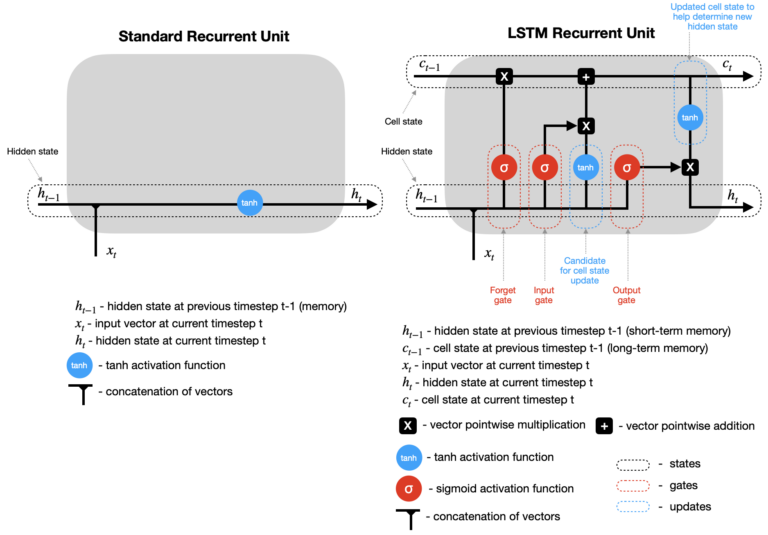

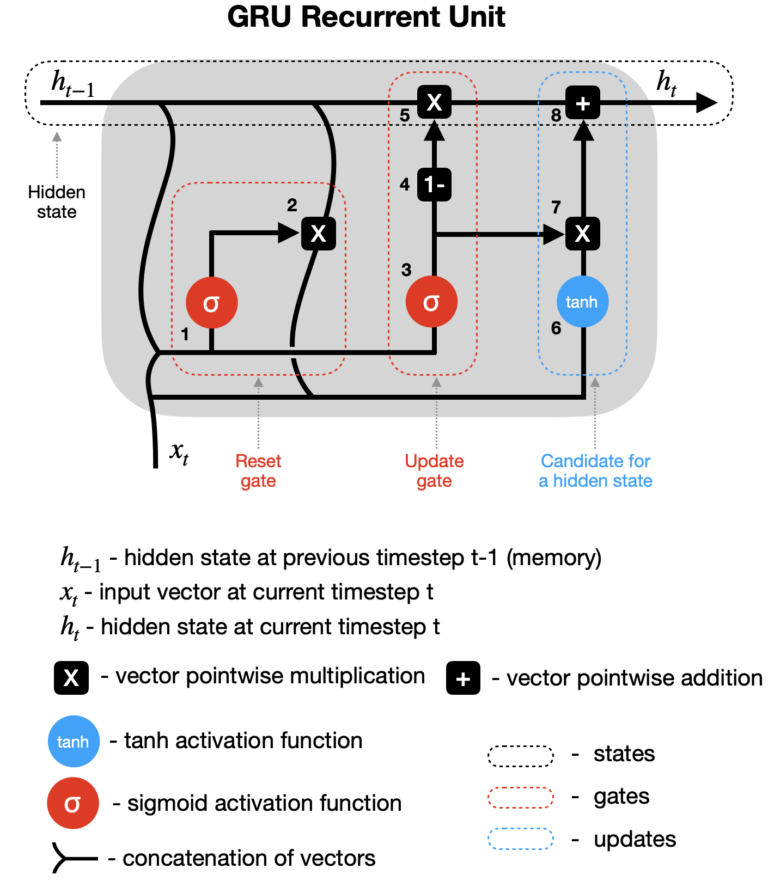

# Autoencoders

**Autoencoders** are a particular type of neural network, just like classifiers. Autoencoders are similar to classifiers in the sense that they compress data. However, where classifiers condense all the data of an image into a single label, autoencoders compress the data into a **latent vector**, often denoted $z$ in literature, with the goal of preserving the opportunity to recreate the exact same image in the future. Because autoencoders learn representations instead of labels, autoencoders belong to representation learning, a subfield of machine learning, but not necessarily deep learning.

While recreating the same data from a compressed version might seem like an impossible task. However, _you_ can actually do the same. You probably have no difficulty memorizing the following sequence:

$$1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27...$$

I bet you haven't looked at every item, but you can still write down the sequence perfectly because you recognized a pattern: all uneven numbers, starting from 1.

This is what autoencoders do: they find patterns in data.

## Architecture
Autoencoders consist of two networks:

* Encoder
* Decoder

The goal of the **encoder** is to compress an image, video, or any piece of data that can be represented as a tensor, into a _latent vector_. The **decoder** does, as you might have guessed, the exact opposite.

To maximize performance, minimize the loss that is, encoders and decoders are typically symmetrical together. Naturally, the input size is equal to the output size of an autoencoder.

Autoencoders always have less input neurons in the middle layer than in the input and output layer. This is called the **bottleneck**. If it weren't for this bottleneck, the autoencoders could just copy this data over from the input to the output layer without compressing it.

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) [source](https://en.wikipedia.org/wiki/File:Autoencoder_structure.png)

## Training

Encoders and decoders _can_ be trained separately, but usually they are trained in one go. In order to do so, one stacks the coders together in one **stacked autoencoder**.

If one desires to train autoencoders separately, one starts by using the first hidden layer, discaring every other layer, except for the input and output layers of course. He uses the original training data at this point. Next, he uses the latent vector $z$ learnt by this mini-autoencoder and trains another autoencoder in the same way, treating the latent vectors as original data. Once the desired depth is reached, one can stack all output layers, which provided the latent vectors, together in a sinle encoder. This approach is not used in practise a lot, but literature might refer to it as greedy layerwise training so it's good to know what it means.

## Applications

While the phase "finding patterns" might not seem very interesting, there are a lot of exciting applications of autoencoders. We will look at three of those today:

1. Dense autoencoder: compressing data.
2. Convolutional autoencoder: a building block of DCGANs, self-supervised learning.
3. Denoising autoencoder: removing noise from poor training data.

While all of these applications use pattern finding, they have different use cases making autoencoders one of the most exciting topics of machine learning.

In [ ]:
import torch
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example usage (dummy data)
input_dim = 784 # For flattened 28x28 images
latent_dim = 32 # Example latent dimension

# Instantiate the autoencoder model
autoencoder_model = Autoencoder(input_dim, latent_dim)

print("Autoencoder model defined.")
print(autoencoder_model)

# Create a dummy input tensor (batch_size, input_dim)
dummy_input = torch.randn(16, input_dim)

# Pass the dummy input through the model
decoded_output = autoencoder_model(dummy_input)

print("\nInput shape:", dummy_input.shape)
print("Output shape:", decoded_output.shape) # Should match input shape

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np # Import numpy for converting tensors to numpy arrays

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load MNIST dataset
# We'll flatten the images to a 1D tensor for the simple MLP autoencoder
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)) # Flatten the image
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Ensure the model is moved to the device
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error for reconstruction loss
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=1e-3) # Adam optimizer

num_epochs = 10 # Number of training epochs

print("Starting Autoencoder training...")
for epoch in range(num_epochs):
    autoencoder_model.train() # Set model to training mode
    running_loss = 0.0

    for data in train_loader:
        inputs, _ = data # We only need the inputs for autoencoding
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder_model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) # Accumulate loss weighted by batch size

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

print("Autoencoder training finished.")

autoencoder_model.eval() # Set model to evaluation mode
with torch.no_grad():
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)

    # Get reconstructions
    reconstructions = autoencoder_model(images)

    # Select a few images and their reconstructions to display
    num_images_to_display = 5
    original_images = images[:num_images_to_display].cpu().numpy().reshape(-1, 28, 28)
    reconstructed_images = reconstructions[:num_images_to_display].cpu().numpy().reshape(-1, 28, 28)

    plt.figure(figsize=(10, 4))
    for i in range(num_images_to_display):
        # Display original images
        ax = plt.subplot(2, num_images_to_display, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_display // 2:
            ax.set_title("Original images")

        # Display reconstructed images
        ax = plt.subplot(2, num_images_to_display, i + 1 + num_images_to_display)
        plt.imshow(reconstructed_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_display // 2:
            ax.set_title("Reconstructed images")
    plt.tight_layout()
    plt.show()


# Variational autoencoders (VAEs)


A VAE learns stochastic mappings between an observed $\mathbf{x}$-space, whose empirical distribution $q_{\mathcal{D}}(\mathbf{x})$ is typically complicated, and a latent $\mathbf{z}$-space, whose distribution can be relatively simple. The generative model learns a joint distribution $p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})$ that is often factorized as $p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})=p_{\boldsymbol{\theta}}(\mathbf{z}) p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z})$, with a prior distribution over latent space $p_{\boldsymbol{\theta}}(\mathbf{z})$, and a stochastic decoder $p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z})$. The stochastic encoder $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})$, also called inference model, approximates the true but intractable posterior $p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})$ of the generative model.

For any choice of inference model $q_\phi(\mathbf{z} \mid \mathbf{x})$, including the choice of variational parameters $\phi$, we have:

$$
\begin{aligned}
\log p_{\boldsymbol{\theta}}(\mathbf{x}) & =\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x})\right] \\
& =\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\left[\log \left[\frac{p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})}{p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})}\right]\right] \\
& =\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\left[\log \left[\frac{p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})} \frac{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}{p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})}\right]\right] \\
& =\underbrace{\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\left[\log \left[\frac{p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} \mid \mathbf{x})}\right]\right]}_{=\mathcal{L}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\mathbf{x})}+\underbrace{\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\left[\log \left[\frac{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}{p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})}\right]\right]}_{=D_{K L}\left(q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \| p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})\right)}
\end{aligned}
$$


The second term in this equation is the Kullback-Leibler (KL) divergence between $q_\phi(\mathbf{z} \mid \mathbf{x})$ and $p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})$, which is non-negative:

$$
D_{K L}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})\right) \geq 0
$$

and zero if, and only if, $q_\phi(\mathbf{z} \mid \mathbf{x})$ equals the true posterior distribution.

The first term is the variational lower bound, also called the evidence lower bound (ELBO):

$$
\mathcal{L}_{\boldsymbol{\theta}, \phi}(\mathbf{x})=\mathbb{E}_{q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})-\log q_\phi(\mathbf{z} \mid \mathbf{x})\right]
$$


Due to the non-negativity of the KL divergence, the ELBO is a lower bound on the log-likelihood of the data.

$$
\begin{aligned}
\mathcal{L}_{\boldsymbol{\theta}, \phi}(\mathbf{x}) & =\log p_{\boldsymbol{\theta}}(\mathbf{x})-D_{K L}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})\right) \\
& \leq \log p_{\boldsymbol{\theta}}(\mathbf{x})
\end{aligned}
$$

It can be understood that maximization of the ELBO $\mathcal{L}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\mathbf{x})$ w.r.t. the parameters $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$, will concurrently optimize the two things we care about:
1. It will approximately maximize the marginal likelihood $p_{\boldsymbol{\theta}}(\mathbf{x})$. This means that our generative model will become better.
2. It will minimize the KL divergence of the approximation $q_\phi(\mathbf{z} \mid \mathbf{x})$ from the true posterior $p_{\boldsymbol{\theta}}(\mathbf{z} \mid \mathbf{x})$, so $q_\phi(\mathbf{z} \mid \mathbf{x})$ becomes better.


Apply Bayes rule $\log p_\theta(z \mid x)=\log p_\theta(x, z)-\log p_\theta(x)$ and the factorization $p_\theta(x, z)= p_\theta(z) p_\theta(x \mid z)$ to rewrite the ELBO as a reconstruction term minus a KL to the prior.

$$
\mathcal{L}_{\theta, \phi}(x)=\mathbb{E}_{q_\phi(z \mid x)}\left[\log p_\theta(x \mid z)\right]-D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p_\theta(z)\right)
$$

In practive we minimize -ELBO!

**Sampling from latent distribution:** To get a latent vector $\mathbf{z}$ for the decoder, a VAE **samples** from the distribution defined by the encoder's output (i.e., from $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2)$). This sampling process introduces stochasticity into the latent representation.

**Reparameterization trick:** The sampling step from the latent distribution is not directly differentiable, which poses a problem for backpropagation. VAEs overcome this using the **reparameterization trick**. Instead of sampling $\mathbf{z}$ directly from $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2)$, we sample a standard normal variable $\boldsymbol{\epsilon} \sim \mathcal{N}(0, 1)$ and compute $\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}$ (where $\odot$ is element-wise multiplication). This allows the gradients to flow through $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$, enabling end-to-end training.

The primary strength of VAEs lies in their **generative capability**. By sampling random latent vectors from the prior distribution (e.g., $\mathcal{N}(0, 1)$) and passing them through the trained decoder, we can generate entirely **new data samples** that are similar to the training data.

More information in article: "An Introduction to Variational Autoencoders"



In [ ]:
import torch
from torch import nn
import torch.nn.functional as F # Import F for functional operations like KL divergence

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        # Latent space mapping: output mean and log variance
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid() # Use Sigmoid for output values between 0 and 1 (like pixel values)
        )

    def encode(self, x):
        """Pass input through the encoder to get latent distribution parameters."""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Applies the reparameterization trick to sample from the latent distribution."""
        std = torch.exp(0.5 * logvar) # Calculate standard deviation from log variance
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        # WRITE YOUR CODE HERE           # Reparameterization trick
        return z

    def decode(self, z):
        """Pass a latent sample through the decoder to reconstruct the input."""
        return self.decoder(z)

    def forward(self, x):
        """Full forward pass of the VAE."""
        mu, logvar = self.encode(x)      # Get latent distribution parameters
        z = self.reparameterize(mu, logvar) # Sample from the latent distribution
        reconstruction = self.decode(z)   # Reconstruct the input
        return reconstruction, mu, logvar

# Example usage (dummy data)
input_dim = 784 # For flattened 28x28 images (e.g., MNIST)
hidden_dim = 256 # Example hidden layer dimension
latent_dim = 32 # Example latent space dimension

# Instantiate the VAE model
vae_model = VAE(input_dim, hidden_dim, latent_dim)

print("VAE model defined:")
print(vae_model)

# Create a dummy input tensor (batch_size, input_dim)
dummy_input = torch.randn(16, input_dim)

# Pass the dummy input through the model
reconstruction, mu, logvar = vae_model(dummy_input)

print("\nInput shape:", dummy_input.shape)
print("Reconstruction shape:", reconstruction.shape) # Should match input shape
print("Mean shape:", mu.shape) # Should be (batch_size, latent_dim)
print("Log Variance shape:", logvar.shape) # Should be (batch_size, latent_dim)


# VAE loss function in our case

The training objective for a Variational Autoencoder (VAE) is to minimize a loss function that encourages both accurate reconstruction of the input and regularization of the latent space. This loss function is composed of two main parts:

1.  **Reconstruction loss:** In our case it will be binary cross-entropy:
    $$
    \mathcal{L}_{\text{reconstruction}}(\mathbf{x}, \mathbf{\hat{x}}) = -\sum_i \left( x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i) \right)
    $$
    where $\mathbf{x}$ is the original input and $\mathbf{\hat{x}}$ is the reconstructed output. This loss term encourages the decoder to generate outputs that are pixel-wise close to the original inputs.

2.  **KL divergence loss (this expression could be obtained for gaussians):**
    $$
    D_{\text{KL}}(\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2) \parallel \mathcal{N}(0, 1)) = \frac{1}{2} \sum_{j=1}^L (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)
    $$
    where $L$ is the dimensionality of the latent space, $\mu_j$ and $\sigma_j^2$ are the mean and variance for the $j$-th dimension of the latent distribution learned by the encoder. Minimizing this term encourages the encoder's latent distributions to be centered around zero and have unit variance, making the latent space more structured and easier to sample from for generation.

The total VAE loss is the sum of these two components:
$$
\mathcal{L}_{\text{VAE}} = \mathcal{L}_{\text{reconstruction}} + \beta \cdot D_{\text{KL}}(\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2) \parallel \mathcal{N}(0, 1))
$$

In [ ]:
import torch.nn.functional as F

def vae_loss_function(reconstruction, original_input, mu, logvar):
    """
    Calculates the VAE loss, combining reconstruction loss and KL divergence.
    """
    # Reconstruction loss (e.g., Binary Cross-Entropy for pixel values between 0 and 1)
    # For simplicity and consistency with the Sigmoid output, we use BCEWithLogitsLoss
    # but apply it to the raw outputs before Sigmoid if using a different output activation.
    # Here, with Sigmoid output, we can use binary_cross_entropy directly with the output.
    reconstruction_loss = F.binary_cross_entropy(reconstruction, original_input, reduction='sum')

    # KL Divergence loss
    # D_KL(N(mu, sigma^2) || N(0, 1)) = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # log(sigma^2) is logvar, sigma^2 is exp(logvar)
    kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE loss
    total_loss = reconstruction_loss + kl_divergence_loss

    return total_loss, reconstruction_loss, kl_divergence_loss


dummy_original_input = torch.randn_like(reconstruction) # Using randn_like for dummy data matching shape and device
dummy_original_input = torch.sigmoid(dummy_original_input) # Ensure values are between 0 and 1 to simulate image data

# Calculate the VAE loss
total_loss, recon_loss, kl_loss = vae_loss_function(reconstruction, dummy_original_input, mu, logvar)

print("\nDemonstrating VAE Loss Calculation:")
print(f"Reconstruction Loss (dummy): {recon_loss.item():.4f}")
print(f"KL Divergence Loss (dummy): {kl_loss.item():.4f}")
print(f"Total VAE Loss (dummy): {total_loss.item():.4f}")


In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load MNIST dataset (assuming it's already downloaded from previous steps)
# We'll flatten the images to a 1D tensor for the simple MLP VAE
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)) # Flatten the image
])

train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the VAE model (assuming it's already defined from the previous step)
# vae_model = VAE(input_dim, hidden_dim, latent_dim) # Assuming these variables are set

# Ensure the model is moved to the device
vae_model.to(device)


# Define Optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3) # Adam optimizer

num_epochs = 20 # Number of training epochs

print("Starting VAE training...")
vae_model.train() # Set model to training mode initially
for epoch in range(num_epochs):
    total_train_loss = 0.0

    for data in train_loader:
        inputs, _ = data # We only need the inputs for VAE
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstruction, mu, logvar = vae_model(inputs)
        total_loss, recon_loss, kl_loss = vae_loss_function(reconstruction, inputs, mu, logvar)

        # Backward pass and optimize
        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item()

    epoch_loss = total_train_loss / len(train_loader.dataset) # Average loss per sample
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

print("VAE training finished.")

vae_model.eval() # Set model to evaluation mode
with torch.no_grad():
    # Sample random latent vectors from a standard normal distribution
    num_samples_to_generate = 10 # Number of new images to generate
    # latent_dim is assumed to be defined from the VAE model definition
    random_latent_vectors = torch.randn(num_samples_to_generate, latent_dim).to(device)

    # Pass sampled latent vectors through the decoder
    generated_images_flat = vae_model.decode(random_latent_vectors)

    # Reshape generated data back into image format (28x28 for MNIST)
    generated_images = generated_images_flat.cpu().numpy().reshape(-1, 28, 28)

    # Display the generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_samples_to_generate):
        ax = plt.subplot(1, num_samples_to_generate, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle("Generated Images from VAE Latent Space")
    plt.tight_layout()
    plt.show()


# Supervised training for RANS flows around airfoils

## Overview

For this example of supervised training
we target turbulent airflows around wing profiles: the learned operator should provide the average motion
and pressure distribution around a given airfoil geometry for different Reynolds numbers and angles of attack.
Thus, inputs to the neural network are airfoil shape, Reynolds numbers, and angle of attack, and it should compute
a time averaged velocity field with 2 components, and the pressure field around the airfoil.

This is classically approximated with _Reynolds-Averaged Navier Stokes_ (RANS) models, and this
setting is still one of the most widely used applications of Navier-Stokes solvers in industry.
However, instead of relying on traditional numerical methods to solve the RANS equations,
we now aim for training a surrogate model via a neural network that completely bypasses the numerical solver.

## Formulation

Our learning task is pretty straight-forward, and can be written as

$$\begin{aligned}
\text{arg min}_{\theta} \sum_i ( f(x_i ; \theta)-y^*_i )^2 ,
\end{aligned}$$

where $x$ and $y^*$ each consist of a set of physical fields,
and the index $i$ evaluates the difference across all discretization points in our data sets.

The goal is to infer velocity $\mathbf{u} = u_x,u_y$ and a pressure field $p$ in a computational domain $\Omega$
around the airfoil in the center of $\Omega$.
$u_x,u_y$ and $p$ each have a dimension of $128^2$.
As inputs we have the Reynolds number $\text{Re} \in \mathbb{R}$, the angle of attack
$\alpha \in \mathbb{R}$, and the airfoil shape $\mathbf{s}$ encoded as a rasterized grid with $128^2$.
 $\text{Re}$ and $\alpha$ are provided in terms of the freestream flow velocity $\mathbf{f}$, the x and y components of which are represented as constant fields of the same size, and contain zeros in the airfoil region.
Thus, put together, both input and output have the same dimensions: $x,y^* \in \mathbb{R}^{3\times128\times128}$. The inputs contain
$[f_x,f_y,\text{mask}]$, while the outputs store the channels $[p,u_x,u_y]$.
This is exactly what we'll specify as input and output dimensions for the NN below.

A point to keep in mind here is that our quantities of interest in $y^*$ contain three different physical fields. While the two velocity components are quite similar in spirit, the pressure field typically has a different behavior with an approximately squared scaling with respect to the velocity (cf. [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli%27s_principle)). This implies that we need to be careful with simple summations (as in the minimization problem above), and that we should take care to normalize the data. If we don't take care, one of the components can dominate and the aggregation in terms of mean will lead the NN to spend more resources to learn the large component rather than the other ones causing smaller errors.

## Dataset generation description (from paper)

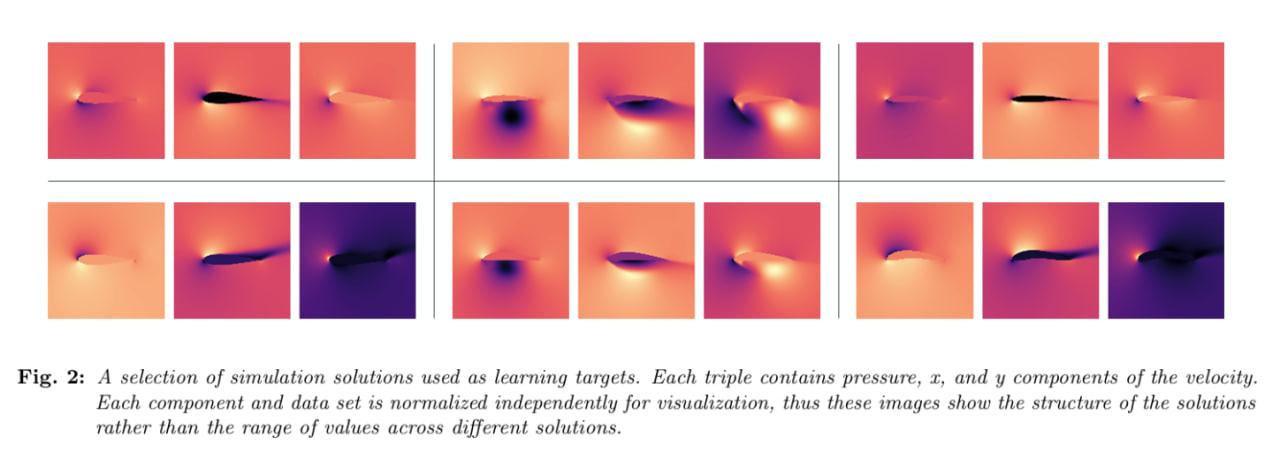

In order to generate ground truth data for training, authors compute the velocity and pressure distributions of flows around airfoils. Author consider a space of solutions with a range of Reynolds numbers $R e=[0.5,5]$ million, incompressible flow, and angles of attack in the range of $\pm 22.5$ degrees. They obtained 1505 different airfoil shapes from the UIUC database [SoIaUCAD96], which were used to generate input data in conjunction with randomly sampled freestream conditions from the range described above. The RANS simulations make use of the widely used SA [SA92] one equation turbulence model, and solutions are calculated with the open source code OpenFOAM. Here we employ a body-fitted triangle mesh, with refinement near the airfoil. At the airfoil surface, the triangle mesh has an average edge length of $1 / 200$ to resolve the boundary layer of the flow. The discretization is coarsened to an edge length of $1 / 16$ near the domain boundary, which has an overall size of $8 \times 8$ units. The airfoil has a length of 1 unit. Typical examples from the training data set are shown in Fig. 2.

While typical RANS solvers, such as the one from OpenFOAM, require large distances for the domain boundaries in order to reduce their negative impact on the solutions around the airfoil, we can focus on a smaller region of $2 \times 2$ units around the airfoil for the deep learning task. As our model directly learns from reference data sets that were generated with a large domain boundary distance, we do not need to reproduce solution in the whole space where the solution was computed, but rather can focus on the region in the vicinity of the airfoil without impairing the solution.

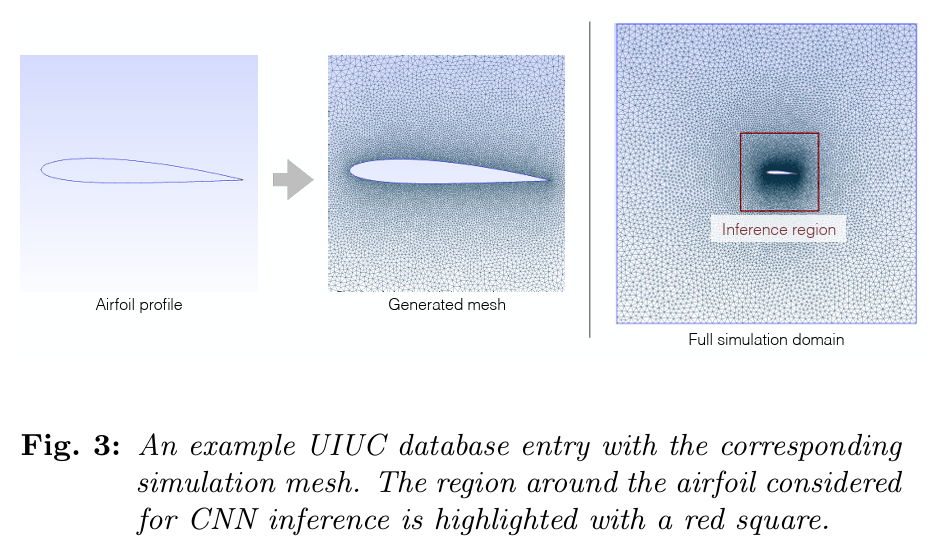

To facilitate NN architectures with convolutional layers, we resample this region with a Cartesian $128^2$ grid to obtain the ground truth pressure and velocity data sets, as shown in Fig. 3. The re-sampling is performed with a linear weighted interpolation of cell-centered values with a spacing of $1 / 64$ units in OpenFOAM. As for the domain boundaries, we only need to ensure that the original solution was produced with a sufficient resolution to resolve the boundary layer.

## Freestream velocity $ \mathbf{U}_\infty $ (what it is & how we encode it)

- **Definition.** The **freestream velocity** is the uniform, undisturbed flow far away from the airfoil.
  - Magnitude: $ U_\infty $  $[{\rm m/s}]$
  - Direction via angle of attack $ \alpha $: $ \mathbf{U}_\infty = (U_\infty \cos\alpha,\; U_\infty \sin\alpha) $.

- **Why it matters.**
  - Sets the operating point and the **Reynolds number** $ \displaystyle Re=\frac{\rho U_\infty c}{\mu} $.

## Code coming up...

Let's get started with the implementation. Note that we'll skip the data generation process here. The code below is adapted from {cite}`thuerey2020dfp` and [this codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Below, we'll simply use a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/). First, let's import the required module, and install the dataloader from git.

In [ ]:
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

!pip install --upgrade --quiet git+https://github.com/tum-pbs/pbdl-dataset
from pbdl.torch.loader import Dataloader

The next cell will download the training data from HuggingFace, which can take a moment... The PBDL dataloader call below directly splits it into 320 samples for training, and 80 samples for validation. These validation samples are using the same airfoil shapes as the training samples, but different conditions (later on we'll download new shapes for testing).

In [ ]:
BATCH_SIZE = 10

loader_train, loader_val = Dataloader.new_split(
    [320, 80],
    "airfoils",
    batch_size=BATCH_SIZE, normalize_data=None,
)

## RANS training data

Now we have the training and validation data. In general it's very important to understand the data we're working with as much as possible (for any ML task the _garbage-in-gargabe-out_ principle definitely holds). We should at least understand the data in terms of dimensions and rough statistics, but ideally also in terms of content. Otherwise we'll have a very hard time interpreting the results of a training run. And despite all the _AI magic_: if you can't make out any patterns in your data, NNs most likely also won't find any useful ones.

Hence, let's look at one of the training samples. The following is just some helper code to show images side by side.

In [ ]:
def plot(a1, a2, mask=None, stats=False, bottom="NN Output", top="Reference", title=None):
    c = []
    if mask is not None: mask = np.asarray(mask)
    for i in range(3):
        a2i = np.asarray(a2[i])
        if mask is not None: a2i = a2i - mask*a2i # optionally mask out inner region
        b = np.flipud(np.concatenate((a2i, a1[i]), axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b)
        if stats:
            print("Stats %d: " % i + format([min, mean, max]))
        b -= min
        b /= max - min
        c.append(b)
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    axes.set_xticks([]) ; axes.set_yticks([])
    im = axes.imshow(np.concatenate(c, axis=1), origin="upper", cmap="magma")
    fig.colorbar(im, ax=axes)
    axes.set_xlabel("p, ux, uy")
    axes.set_ylabel("%s           %s" % (bottom, top))
    if title is not None: plt.title(title)
    plt.show()

inputs, targets = next(iter(loader_train))
plot(inputs[0], targets[0], stats=False, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (free-ux, free-uy, mask),\n with the 3 output channels (p,ux,uy) at the bottom")


## Network setup

Now we can set up the architecture of our neural network, we'll use a fully convolutional U-net. This is a widely used architecture that uses a stack of convolutions across different spatial resolutions. The main deviation from a regular conv-net is the hierarchy (for a global receptive field), and to introduce _skip connections_ from the encoder to the decoder part. This ensures that no information is lost during feature extraction. (Note that this only works if the network is to be used as a whole. It doesn't work in situations where we'd, e.g., want to use the decoder as a standalone component.)

Here's a overview of the architecure:

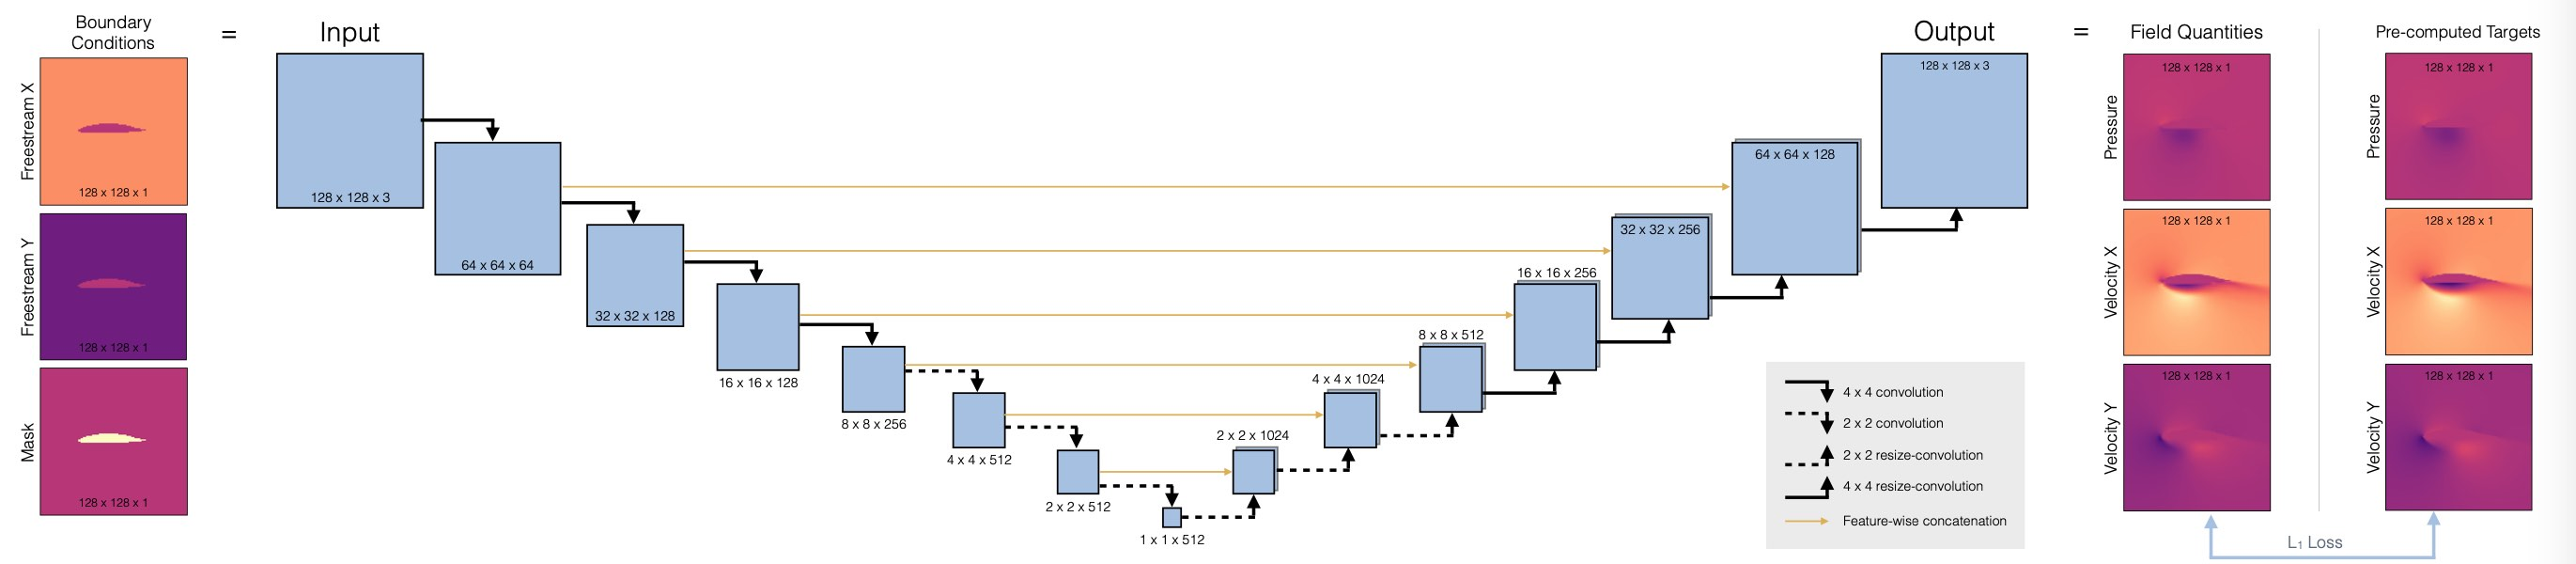![An overview of the U-net we're using for this learning task](resources/supervised-airfoils-unet.jpg)

First, we'll define a helper to set up a convolutional block in the network, `blockUNet`. Note, we don't use any pooling! Instead we use strides and transpose convolutions (these need to be symmetric for the decoder part, i.e. have an uneven kernel size), following [best practices](https://distill.pub/2016/deconv-checkerboard/). The full pytroch neural network is managed via the `DfpNet` class.

In [ ]:
def blockUNet( in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0.0 ):

    block = nn.Sequential()

    if not transposed:
        block.add_module(
            "%s_conv" % name,
            nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True),
        )
    else:
        # Use nn.ConvTranspose2d for transposed convolution
        # The kernel size, stride, and padding need to be specified for ConvTranspose2d
        # To effectively reverse a Conv2d with kernel size K, stride S, padding P,
        # the ConvTranspose2d should have kernel size K, stride S, and padding P.
        # However, the original blockUNet used size-1 kernel for the Conv2d after Upsample.
        # Let's use the original size for ConvTranspose2d for direct reversal concept.
        block.add_module(
            "%s_tconv" % name,
            nn.ConvTranspose2d( in_c, out_c, kernel_size=size, stride=2, padding=pad, output_padding=0, bias=True),
        )

    if bn:
        block.add_module("%s_bn" % name, nn.BatchNorm2d(out_c))
    if dropout > 0.0:
        block.add_module("%s_dropout" % name, nn.Dropout2d(dropout, inplace=True))

    if activation:
        if relu:
            block.add_module("%s_relu" % name, nn.ReLU(inplace=True))
        else:
            block.add_module("%s_leakyrelu" % name, nn.LeakyReLU(0.2, inplace=True))

    return block


class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.0):
        super(DfpNet, self).__init__()
        channels = int(2**channelExponent + 0.5)

        # WRITE CODE HERE


    def forward(self, input):
        # WRITE CODE HERE
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Next, we can initialize an instance of the `DfpNet`.

Below, the `EXPO` parameter here controls the exponent for the feature maps of our Unet: this directly scales the network size (an exponent of 4 gives a network with ca. 585k parameters). This is a medium sized network for a generative NN with $3 \times 128^2 = \text{ca. }49k$ outputs, and still yields fast training times. Hence it's a good starting point. The `weights_init` function initializes the conv net to a reasonable initial value range, so that we can directly train with a fixed learning rate (otherwise learning rate schedules are highly recommended).

In [ ]:
# channel exponent to control network size
EXPO = 4

torch.set_default_device("cuda:0")
#torch.set_default_device("cpu")
device = torch.get_default_device()

net = DfpNet(channelExponent=EXPO)
net.apply(weights_init)

# crucial parameter to keep in view: how many parameters do we have?
nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
print("Trainable params: {}   -> crucial! always keep in view... ".format( sum([np.prod(p.size()) for p in nn_parameters]) ))

LR   = 0.0002          # learning rate

loss = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=0.0)

As the subtle hint in the print statement indicates, the parameter count is a crucial number to have in view when training NNs. It's easy to change settings, and get a network that has millions of parameters, and as a result can cause wasting resources at training time (and potentially training instabilities).
The number of parameters definitely has to be matched with the amount of training data, and should also scale with the depth of the network. How exactly these three relate to each other is problem dependent, though.

## Training

Finally, we can train the NN. This step can take a while, as the training runs over all 320 samples 100 times, and continually evaluates the validation samples to keep track of how well the current state of the NN is doing.

In [ ]:
EPOCHS = 200    # number of training epochs

loss_hist = []
loss_hist_val = []

if os.path.isfile("dfpnet"): # NT_DEBUG
    print("Found existing network, loading & skipping training")
    net.load_state_dict(torch.load("dfpnet"))

else:
    print("Training from scratch...")
    pbar = tqdm(initial=0, total=EPOCHS, ncols=96)
    for epoch in range(EPOCHS):

        # training
        net.train()
        loss_acc = 0
        for i, (inputs, targets) in enumerate(loader_train):
            inputs = inputs.float()
            targets = targets.float()

            net.zero_grad()
            outputs = net(inputs)
            lossL1 = loss(outputs, targets)
            lossL1.backward()
            optimizer.step()
            loss_acc += lossL1.item()

        loss_hist.append(loss_acc / len(loader_train))

        # evaluate validation samples
        net.eval()
        loss_acc_v = 0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader_val):
                inputs = inputs.float()
                targets = targets.float()

                outputs = net(inputs)
                loss_acc_v += loss(outputs, targets).item()

        loss_hist_val.append(loss_acc_v / len(loader_val))
        pbar.set_description("loss train: {:7.5f}, loss val: {:7.5f}".format( loss_hist[-1], loss_hist_val[-1] ) , refresh=False); pbar.update(1)

    torch.save(net.state_dict(), "dfpnet")
    print("training done, saved network weights")

loss_hist = np.asarray(loss_hist)
loss_hist_val = np.asarray(loss_hist_val)

The NN is trained, the losses should have gone down in terms of absolute values: With the standard settings from an initial value of around 0.2 for the validation loss, to ca. 0.01 after training.

Let's look at the graphs to get some intuition for how the training progressed over time. This is typically important to identify longer-term trends in the training. In practice it's tricky to spot whether the overall trend of 100 or so noisy numbers in a command line log is going slightly up or down - this is much easier to spot in a visualization.

In [ ]:
plt.plot(np.arange(loss_hist.shape[0]), loss_hist, "b", label="Training loss")
plt.plot(np.arange(loss_hist_val.shape[0]), loss_hist_val, "g", label="Validation loss")
plt.legend()
plt.show()

You should see a curve that goes down for ca. 40 epochs, and then starts to flatten out. In the last part, it's still slowly decreasing, and most importantly, the validation loss is not increasing. This would be a certain sign of overfitting, and something that we should avoid. (Try decreasing the amount of training data artificially, then you should be able to intentionally cause overfitting.)

Note that the validation loss is generally higher above, as the dataset here is relatively small. At some point, the network will not be able to get new information from it that transfers to the validation samples.

A general word of caution here: never evaluate your network with training data. That won't tell you much because overfitting is a very common problem. At least use data the network hasn't seen before, i.e. validation data, and if that looks good, try some more different (at least slightly out-of-distribution) inputs, i.e., _test data_. The next cell runs the trained network on a batch of samples from the validation data, and displays one with the `plot` function.

In [ ]:
net.eval()
inputs, targets = next(iter(loader_val))
inputs = inputs.float()
targets = targets.float()

outputs = net(inputs)

outputs = outputs.data.cpu().numpy()
inputs = inputs.cpu()
targets = targets.cpu()
plot(targets[0], outputs[0], mask=inputs[0][2], title="Validation sample")

This shows a good resemblance here between input out network output. The region around the airfoil is typically still a bit noisy (this is caused by the Dirichlet boundary, and could be alleviated with a modified loss and larger networks). The pressure values are typically the most difficult ones to learn. We'll save the more detailed evaluation for the test data, though.

## Test evaluation

Now let's look at actual test samples: In this case we'll use new airfoil shapes as out-of-distribution (OOD) data. These are shapes that the network has not seen in any training samples, and hence it tells us a bit about how well the NN generalizes to unseen inputs (the validation data wouldn't suffice to draw conclusions about generalization).

We'll use the same visualization as before, and as indicated by the Bernoulli equation, especially the _pressure_ in the first column is a challenging quantity for the network. Due to it's cubic scaling w.r.t. the input freestream velocity and localized peaks, it is the toughest quantity to infer for the network.

The cell below first downloads a smaller archive with these test data samples, and then runs them through the network. The evaluation loop also computes the accumulated L1 error such that we can quantify how well the network does on the test samples.

In [ ]:
loader_test = Dataloader( "airfoils-test", batch_size=1, normalize_data=None, shuffle=False )
loss = nn.L1Loss()

net.eval()
L1t_accum = 0.
for i, testdata in enumerate(loader_test, 0):
    inputs_curr, targets_curr = testdata
    inputs = inputs_curr.float()
    targets = targets_curr.float()

    outputs = net(inputs)

    outputs_curr = outputs.data.cpu().numpy()
    inputs_curr = inputs_curr.cpu()
    targets_curr = targets_curr.cpu()

    L1t_accum += loss(outputs, targets).item()
    if i<3: plot(targets_curr[0] , outputs_curr[0], mask=inputs_curr[0][2], title="Test sample %d"%(i))

print("\nAverage relative test error: {}".format( L1t_accum/len(loader_test) ))

The average test error with the default settings should be close to 0.015. As the inputs are normalized, this means the average relative error across all three fields is around 2.5% w.r.t. the maxima of each quantity. This is not too bad for new shapes, but clearly leaves room for improvement.

Looking at the visualizations, you'll notice that especially high-pressure peaks and pockets of larger y-velocities are missing in the outputs. This is primarily caused by the small network, which does not have enough resources to reconstruct details. The $L^2$ also has an averaging behavior, and favours larger structures (the surroundings) over localized peaks.

Nonetheless, we have successfully replaced a fairly sophisticated RANS solver with a small and fast neural network architecture. It has GPU support "out-of-the-box" (via pytorch), is differentiable, and introduces an error of only a few per-cent. With additional changes and more data, this setup can be made highly accurate.